---
# Group statistics of pRF overlap

In [1]:
%matplotlib inline

In [2]:
from linescanning import (
    utils,
    plotting,
    prf,
    dataset,
    preproc,
    glm,
    optimal,
    fitting
)
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import io, stats
import pandas as pd
import pRFline
from pRFline.plotting import pRFSpread
from pRFline.utils import SubjectsDict
import seaborn as sns
opj = os.path.join
opd = os.path.dirname

In [3]:
# Load data
ses         = 2
task        = "task-pRF"
base_dir    = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF"
design_dir  = opj(opd(opd(pRFline.__file__)), "data")
fig_dir     = opj(opd(opd(pRFline.__file__)), "results")

In [4]:
verbose = False
fix_bold = True
model = "norm"
fit_nbr = True
downsample = False
nbr_r2_thresh = 0.1

# fetch subject dictionary from pRFline.utils.SubjectsDict
subj_obj = SubjectsDict()
dict_data = subj_obj.dict_data


## Main data parser

Same loop as `overlap.py`, but because everything is run already, it just reads in the existing files

In [5]:
full_dict = {}

process_subjs = list(dict_data.keys())
# process_subjs = ["sub-002", "sub-003","sub-007","sub-008"]

for subject in process_subjs:

    data_output = opj(design_dir, subject)
    
    # initiate dictionary
    full_dict[subject] = {}

    print("\n---------------------------------------------------------------------------------------------------")
    print(f"Dealing with {subject} [{datetime.now().strftime('%Y/%m/%d %H:%M:%S')}]")
    print("\n-- linescanning --")

    # add line-scanning key
    full_dict[subject]["lines"] = {}

    ####################################################################################################
    # LINE-SCANNING BIT
    ####################################################################################################

    #---------------------------------------------------------------------------------------------------
    # get directories
    func_dir    = opj(base_dir, subject, f"ses-{ses}", "func")
    anat_dir    = opj(os.path.dirname(func_dir), 'anat')

    run_files   = utils.get_file_from_substring(
        [subject, f"ses-{ses}", f"{task}"], 
        func_dir, 
        exclude=dict_data[subject]["exclude"])
        
    func_file = utils.get_file_from_substring("bold.mat", run_files)
    anat_slices = utils.get_file_from_substring([subject, f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir)
    ref_slices  = utils.match_lists_on(func_file, anat_slices, matcher='run')

    # mind you, the segmentations live in ses-1 space, NOT FREESURFER!
    ses_to_motion = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(base_dir, "derivatives", 'pycortex', subject, 'transforms'))
    run2run = utils.get_file_from_substring(['.txt'], anat_dir)

    #---------------------------------------------------------------------------------------------------
    # PREPROCESSING

    print("Reading in data")
    data_obj = dataset.Dataset(
        func_file,
        use_bids=True,
        verbose=verbose,
        acompcor=True,
        ref_slice=ref_slices,
        ses1_2_ls=ses_to_motion,
        run_2_run=run2run,
        n_pca=5,
        deleted_last_timepoints=300,
        report=False)

    df_func = data_obj.fetch_fmri()

    # select ribbon voxels
    df_ribbon = utils.select_from_df(
        df_func, 
        expression="ribbon", 
        indices=dict_data[subject]["ribbon"])

    # average runs
    avg_psc = df_ribbon.groupby(['subject', "t"]).mean().values.mean(axis=-1)[np.newaxis,:]

    process_data = ["native"]
    if downsample:
        process_data += ["ds"]

    for res in process_data:

        print(f"Dealing with '{res}' as temporal resolution")
        full_dict[subject]["lines"][res] = {}

        # get low-res design 
        dm_f = opj(data_output, f"{subject}_acq-lines_res-{res}_desc-full_design.mat")
        if os.path.exists(dm_f):
            print(f" Reading {dm_f}")
            dm_ = prf.read_par_file(dm_f)               

        input_data = avg_psc.copy()
        tr = 0.105
        if res == "ds":
            tr = 1.5
            new_vols = int((avg_psc.shape[-1]*0.105)/tr)
            input_data = glm.resample_stim_vector(avg_psc.T, new_vols).T

        # sync design matrix and data shapes
        sync_dm = dm_[...,:input_data.shape[-1]]     

        avg_l = prf.pRFmodelFitting(
            input_data,
            design_matrix=sync_dm,
            model=model,
            TR=tr,
            fix_bold_baseline=fix_bold,
            verbose=verbose,
            rsq_threshold=0,
            screen_distance_cm=196,
            grid_nr=40,
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-lines_res-{res}_vox-avg"
        )

        pars_file = opj(avg_l.output_dir, f"{avg_l.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" Fitting {res} avg ribbon")
            print(f"  TR = {tr}; ")
            print(f"  data shape = {input_data.shape}")
            print(f"  design shape = {sync_dm.shape}")
            avg_l.fit()    
        else:
            print(f" Reading {pars_file}")
            avg_l.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["lines"][res] = {}
        full_dict[subject]["lines"][res]["avg"] = avg_l

        # fit across laminae
        input_data = df_ribbon.groupby(['subject', "t"]).mean().values

        vox_ = prf.pRFmodelFitting(
            input_data.T,
            design_matrix=sync_dm,
            model=model,
            TR=tr,
            fix_bold_baseline=fix_bold,
            verbose=verbose,
            rsq_threshold=0,
            screen_distance_cm=196,
            grid_nr=40,
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-lines_res-{res}_vox-ribbon",
            old_params=getattr(avg_l, f"{model}_iter"),
            fix_parameters=[0,1],
            fit_hrf=True
        )

        pars_file = opj(vox_.output_dir, f"{vox_.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" Fitting {res}-ribbon", flush=True)
            print(f"  data shape = {input_data.shape}", flush=True)
            print(f"  design shape = {sync_dm.shape}", flush=True)
            # vox_.fit()
        else:
            print(f" Reading {pars_file}", flush=True)
            vox_.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["lines"][res]["ribbon"] = vox_

    print("Done", flush=True)

    ####################################################################################################
    # 2D-EPI WHOLE-BRAIN BIT
    ####################################################################################################

    print("\n-- whole brain 2D-EPI --")
    
    # add whole-brain key
    full_dict[subject]["wb"] = {}
    full_dict[subject]["vertices"] = {}
    full_dict[subject]["vertices"]["target"] = dict_data[subject]['target']

    # check if we should fit neighbouring voxels of target
    fit_verts = [dict_data[subject]['target']]
    if fit_nbr:
        # fit_verts = subj_obj.get_neighbours(subject=subject, vertices_only=True)
        
        nbr = optimal.Neighbours(
            subject=subject,
            hemi="lh",
            verbose=True
        )

        # read in the distance file; created with `call_distance`
        dist_file = opj(data_output, f"{subject}_hemi-L_desc-V1_distances.json")
        if not os.path.exists(dist_file):
            raise FileNotFoundError(f"Could not find file with distances. Create it with 'call_distance'")

        nbr.distances_to_target(vert_dict=dist_file, hemi="lh")

        mm2 = nbr.find_distance_range(vmax=2)
        mm2_4 = nbr.find_distance_range(vmin=2,vmax=4)
        mm4_6 = nbr.find_distance_range(vmin=4,vmax=6)

        fit_verts = sorted(fit_verts+mm2+mm2_4+mm4_6)

        mm2_idx,mm2_4_idx,mm4_6_idx = [],[],[]
        for ix,vert in enumerate(fit_verts):
            if vert != subj_obj.get_target(subject):
                if vert in mm2:
                    mm2_idx.append(ix)
                elif vert in mm2_4:
                    mm2_4_idx.append(ix)
                elif vert in mm4_6:
                    mm4_6_idx.append(ix)

        full_dict[subject]["vertices"]["2mm"] = mm2_idx.copy()
        full_dict[subject]["vertices"]["4mm"] = mm2_4_idx.copy()
        full_dict[subject]["vertices"]["6mm"] = mm4_6_idx.copy()

        print(f"Fitting {len(fit_verts)-1} neighbouring vertices + target vertex {subj_obj.get_target(subject)}", flush=True)

        full_dict[subject]["vertices"]["orig"] = nbr.lh_dist_to_targ
        
    full_dict[subject]["vertices"]["all"] = fit_verts

    # get directories
    data_dir = opj(base_dir, "derivatives", "pybest", subject, "ses-1", "unzscored")
    data_files = utils.get_file_from_substring("npy", data_dir, exclude="hemi-R")
    design = utils.resample2d(prf.read_par_file(opj(base_dir, "derivatives", "prf", subject, "ses-1", "design_task-2R.mat")), new_size=100)

    # remove first 4 volumes
    cut_vols = 4
    design_cut = design.copy()[...,cut_vols:]

    collect_vox = []
    for ix,data in enumerate(data_files):

        full_dict[subject]["wb"][ix] = {}
        
        # get target vertex data
        vox_data = np.load(data)[cut_vols:,fit_verts]

        # convert to percent change
        vox_psc = utils.percent_change(vox_data, 0, baseline=15)

        # append
        collect_vox.append(vox_psc[...,np.newaxis])

        # fit
        fit_ = prf.pRFmodelFitting(
            vox_psc.T,
            design_matrix=design_cut,
            fix_bold_baseline=fix_bold,
            model=model,
            verbose=verbose,
            rsq_threshold=0,
            TR=1.5,
            screen_distance_cm=210,
            screen_size_cm=dict_data[subject]["screen_size"],
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-2DEPI_run-{ix+1}"
        )

        pars_file = opj(fit_.output_dir, f"{fit_.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" fitting run-{ix+1} [data={fit_.data.shape}]..", flush=True)
            fit_.fit()
        else:
            print(f" reading run-{ix+1}..", flush=True)
            fit_.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["wb"][ix] = fit_

    # average
    collect_vox = np.concatenate(collect_vox, axis=-1)
    avg = np.median(collect_vox, axis=-1)

    # fit average
    avg_epi = prf.pRFmodelFitting(
        avg.T,
        design_matrix=design_cut,
        fix_bold_baseline=fix_bold,
        model=model,
        verbose=verbose,
        rsq_threshold=0,
        TR=1.5,
        screen_distance_cm=210,
        screen_size_cm=dict_data[subject]["screen_size"],
        write_files=True,
        save_grid=False,
        output_dir=data_output,
        output_base=f"{subject}_acq-2DEPI_run-avg"
    )

    pars_file = opj(avg_epi.output_dir, f"{avg_epi.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
    if not os.path.exists(pars_file):
        print(f" fitting run-avg [data={avg_epi.data.shape}]..", flush=True)
        avg_epi.fit()
    else:
        print(f" reading run-avg..", flush=True)
        avg_epi.load_params(
            pars_file, 
            model=model, 
            stage="iter")

    full_dict[subject]["wb"]['avg'] = avg_epi

    print("Done")


---------------------------------------------------------------------------------------------------
Dealing with sub-001 [2022/12/14 13:14:42]

-- linescanning --
Reading in data
Dealing with 'native' as temporal resolution
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_acq-lines_res-native_desc-full_design.mat
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_acq-lines_res-native_vox-avg_model-norm_stage-iter_desc-prf_params.pkl
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_acq-lines_res-native_vox-ribbon_model-norm_stage-iter_desc-prf_params.pkl
Done

-- whole brain 2D-EPI --
Initializing SurfaceCalc
Creating subsurfaces for V1_exvivo.thresh
Reading distances from /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_hemi-L_desc-V1_distances.json
Fitting 169 neighbouring vertices + target vertex 1053
 reading run-1.

## Main summary plot

Contains:

- row of subject-specific plots in visual space with the EPI-runs (grey circles), average EPI (black circle) and the average line pRF across the ribbon (subject-specific color)
- plot of normalized pRFs for all subjects
- r2 for various flavours (e.g., average EPI, EPI-runs, average line)
- Distance to average EPI (from EPI runs, 2mm away, 4mm away, 6mm away and the average line pRF)

In [7]:
colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(dict_data.keys())
cmap_subj = "Pastel1"
sub_colors = sns.color_palette(cmap_subj, len(subjects))


In [6]:
sub = "sub-001"
np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

68

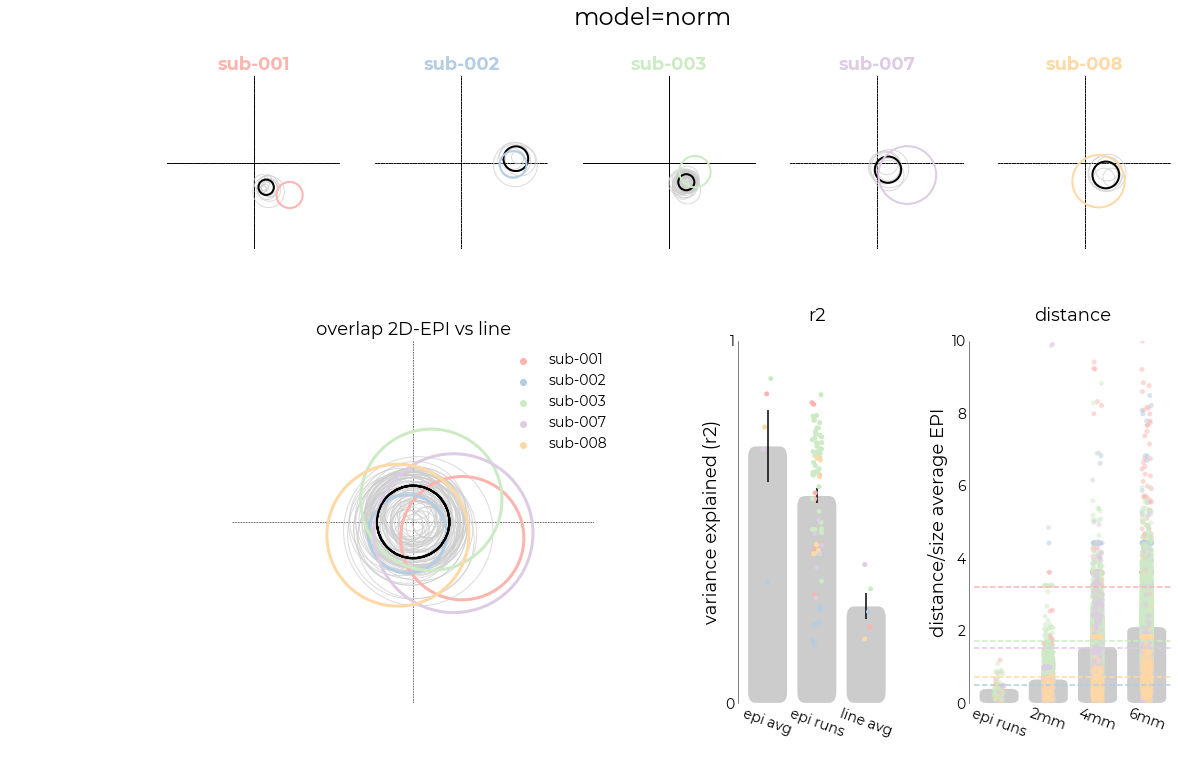

In [131]:
# figure settings
fig = plt.figure(figsize=(18,10))
subfigs = fig.subfigures(nrows=2, height_ratios=[0.5,1])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=3, 
    gridspec_kw={
        'width_ratios': [1,0.3,0.4], 
        'wspace': 0.3})

# axis for pRF overlap plot
axs = axs_avg[0]

r2s, dist, geod = {},{},{}
r2s["subject"], r2s["r2"], r2s["acq"], r2s["name"] = [],[],[],[]
dist["subject"], dist["distance"], dist["acq"], dist["name"] = [],[],[],[]
geod["subject"], geod["d_prf"], geod["d_mm"] = [],[],[]

# if fit_nbr == True, target vertex is last row
est_idx = 0

for ix,sub in enumerate(subjects):

    ax_ = axs_subj[ix]

    for fit in full_dict[sub]['wb']:
        
        # find index of target 
        est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]
        
        if fit != "avg":
            # get parameters from individual runs
            pars,_,_,_ = full_dict[sub]['wb'][fit].plot_vox(
                vox_nr=est_idx,
                model=model,
                stage='iter',
                make_figure=False
            )

            if pars[-1] != 0:
                # get parameters from average
                avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
                    vox_nr=est_idx,
                    model=model,
                    stage='iter',
                    make_figure=False
                )

                # express distance as distance/size
                dist_dva = prf.distance_centers(avg_pars,pars)/avg_pars[2]
                dist["distance"].append(dist_dva)
                dist["subject"].append(sub)
                dist["name"].append("epi runs")
                dist["acq"].append(0)                

                # append r2 to dictionary
                r2s["r2"].append(pars[-1])
                r2s["subject"].append(sub)
                r2s["name"].append("epi runs")
                r2s["acq"].append(1)
                
            # get distance/size of neighbouring vertices
            if fit_nbr:
                nbr_pars = getattr(full_dict[sub]['wb'][fit], f"{model}_iter")
                for nbr in range(nbr_pars.shape[0]):
                    
                    # filter out target vertex
                    if full_dict[sub]["vertices"]["all"][nbr] != full_dict[sub]["vertices"]["target"]:

                        # get parameters from neighbours
                        nbr_estimates = nbr_pars[nbr,:]

                        # plot normalized neighbour
                        nbr_norm = prf.normalize_prf(avg_pars,nbr_estimates)

                        # find x/y of max pRF
                        center = (nbr_norm[0],nbr_norm[1])
                        circ_nbr = plt.Circle(
                            center,
                            nbr_norm[2],
                            ec="r",
                            fill=False,
                            alpha=0.15)
                        # axs.add_artist(circ_nbr)      
                        
                        if nbr in full_dict[sub]["vertices"]["2mm"]:
                            nn = "2mm"
                            ct = 1
                        elif nbr in full_dict[sub]["vertices"]["4mm"]:
                            nn = "4mm"
                            ct = 2
                        elif nbr in full_dict[sub]["vertices"]["6mm"]:
                            nn = "6mm"
                            ct = 3

                        dist_dva = prf.distance_centers(avg_pars,nbr_estimates)/avg_pars[2]
                        dist["distance"].append(dist_dva)
                        dist["subject"].append(sub)
                        dist["name"].append(nn)
                        dist["acq"].append(ct)

                        # also create dataframe with distances in mm and degrees/stdev (this is not super pretty..)
                        geod["subject"].append(sub)
                        geod["d_prf"].append(dist_dva)
                        geod["d_mm"].append(full_dict[sub]["vertices"]["orig"][str(full_dict[sub]["vertices"]["all"][nbr])])

        else:
            r2s["r2"].append(getattr(full_dict[sub]['wb']['avg'], f"{model}_iter")[est_idx,-1])
            r2s["subject"].append(sub)
            r2s["name"].append("epi avg")
            r2s["acq"].append(0)            

        if fit == 0 and ix == 0:

            # create visual field delineation, plot on subject specific axis & average
            plotting.LazyPRF(
                np.zeros((500,500)), 
                [-5,5],
                ax=axs,
                cross_color="k",
                edge_color=None,
                shrink_factor=0.9,
                cmap=cmap1,
                vf_only=True)

        # draw empty visual field for subject
        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax_,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)                

        if fit != "avg":
            # plot normalized pRF
            run_norm = prf.normalize_prf(avg_pars,pars)
            
            # find x/y of max pRF
            center = (run_norm[0],run_norm[1])
            circ2 = plt.Circle(
                center,
                run_norm[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)
        
            axs.add_artist(circ2)

            # add non-normalized to subject specific axis
            circ_run_subj = plt.Circle(
                (pars[0],pars[1]),
                pars[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)

            ax_.add_artist(circ_run_subj)

line_avg_idx_dist = len(np.unique(dist["acq"]))
for ix,sub in enumerate(subjects):

    #re-fetch the index of target vertex
    est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

    # get parameters from average
    avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
        vox_nr=est_idx,
        model=model,
        stage='iter',
        make_figure=False
    )

    circ_avg = plt.Circle(
        (0,0),
        1,
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    axs.add_artist(circ_avg)

    # add average line-scanning
    l_pars,_,_,_ = full_dict[sub]['lines']['native']["avg"].plot_vox(
        model=model,
        stage='iter',
        make_figure=False
    )

    # plot normalized pRF
    line_norm = prf.normalize_prf(avg_pars,l_pars)

    # find x/y of max pRF
    center = (line_norm[0],line_norm[1])
    circ3 = plt.Circle(
        center,
        line_norm[2],
        ec=sub_colors[ix],
        fill=False,
        lw=3)

    axs.add_artist(circ3)

    # add to subject specific axis
    sub_epi = plt.Circle(
        (avg_pars[0],avg_pars[1]),
        avg_pars[2],
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    sub_line = plt.Circle(
        (l_pars[0],l_pars[1]),
        l_pars[2],
        ec=sub_colors[ix],
        fill=False,
        lw=2)

    axs_subj[ix].add_artist(sub_epi)    
    axs_subj[ix].add_artist(sub_line)

    # axs.annotate(sub, xy=center, fontsize=12, ha="center")
    axs_subj[ix].set_title(sub, fontsize=18, color=sub_colors[ix], fontweight="bold")
    axs.set_title("overlap 2D-EPI vs line", fontsize=18)
    
    # append to r2 array
    avg_idx = 2
    if downsample:
        l_ds_pars,_,_,_ = full_dict[sub]['lines']['ds'].plot_vox(
            model=model,
            stage='iter',
            make_figure=False
        )

        avg_idx = 3
        r2s["r2"].append(l_ds_pars[-1])
        r2s["subject"].append(sub)
        r2s["name"].append("line ds")
        r2s["acq"].append(2)        

    r2s["r2"].append(l_pars[-1])
    r2s["subject"].append(sub)
    r2s["name"].append("line avg")
    r2s["acq"].append(avg_idx)

    # append distance
    line_dist = prf.distance_centers(avg_pars, l_pars)/avg_pars[2]
    dist["distance"].append(line_dist)
    dist["subject"].append(sub)
    dist["name"].append("line avg")
    dist["acq"].append(line_avg_idx_dist)

# make dataframe
df_r2 = pd.DataFrame(r2s)
df_dist = pd.DataFrame(dist)
df_geo = pd.DataFrame(geod)

# enforce float
df_r2["r2"] = df_r2["r2"].astype(float)
df_dist["distance"] = df_dist["distance"].astype(float)
df_r2.head()


r2_axs = axs_avg[1]
dist_axs = axs_avg[2]

plotting.LazyBar(
    data=df_r2.sort_values(['acq','subject']),
    x="name",
    y="r2",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=r2_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    points_cmap=cmap_subj,
    points_hue="subject",    
    y_label2="variance explained (r2)",
    title2="r2",
    lim=[0,1],
    ticks=[0,1],
    fancy=True,
    trim_bottom=True
)

plotting.LazyBar(
    data=utils.select_from_df(df_dist, expression=f"acq != {line_avg_idx_dist}").sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=dist_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    bbox_to_anchor=(-1.8,1),
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
    trim_bottom=True,
    lim=[0,10]
)
for ix, sub in enumerate(subjects):
    line_dist = utils.select_from_df(df_dist, expression=(f"acq = {line_avg_idx_dist}", "&", f"subject = {sub}"))["distance"].values[0]
    dist_axs.axhline(line_dist, color=sub_colors[ix], ls="--", zorder=3)

fig.suptitle(f"model={model}", fontsize=24, y=1.05)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-combined+subjects")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

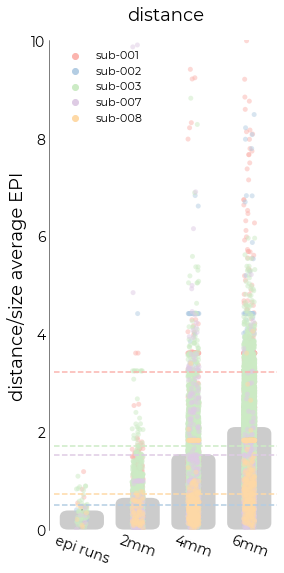

In [129]:
fig,axs = plt.subplots(figsize=(4,9))

plotting.LazyBar(
    data=utils.select_from_df(df_dist, expression=f"acq != {line_avg_idx_dist}").sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    # bbox_to_anchor=(-1.8,1),
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
    trim_bottom=True,
    lim=[0,10]
)

for ix, sub in enumerate(subjects):
    line_dist = utils.select_from_df(df_dist, expression=(f"acq = {line_avg_idx_dist}", "&", f"subject = {sub}"))["distance"].values[0]
    axs.axhline(line_dist, xmin=0, color=sub_colors[ix], ls="--" , zorder=3)

## Distance as curves

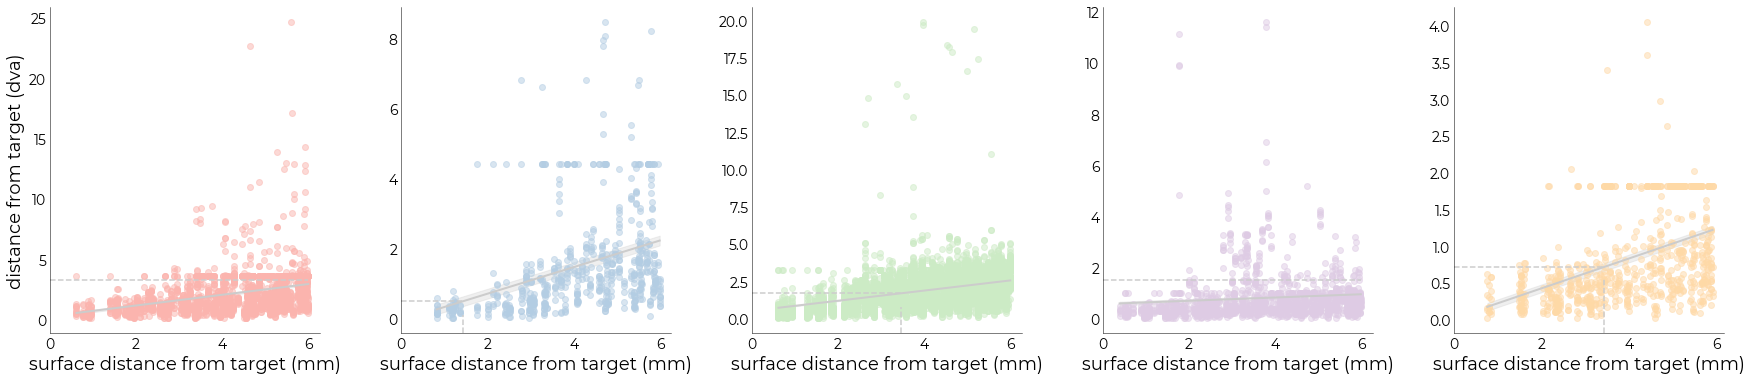

In [11]:
fig,axs = plt.subplots(ncols=len(dict_data),figsize=(6*len(dict_data),6), gridspec_kw={'wspace': 0.3})

fit_order = 1
add_overlap = True
add_data = True
cmap1 = utils.make_binary_cm(colors[0])
for sub_ix,sub in enumerate(subjects):

    ax = axs[sub_ix]

    # get subject-specific dataframe
    data = utils.select_from_df(df_geo, expression=f"subject = {sub}").sort_values("d_mm")

    # and depths
    mm = data["d_mm"].values
    dva = data["d_prf"].values

    if add_data:
        ax.plot(mm,dva,"o",color=sub_colors[sub_ix], alpha=0.5)
        add_overlap = False
        use_color = "#cccccc"
    else:
        use_color = sub_colors[sub_ix]

    # throw all subjects in CurveFitter
    cf = fitting.CurveFitter(
        dva, 
        x=mm,
        order=fit_order, 
        verbose=False)

    y_lbl = None
    if sub_ix == 0:
        y_lbl = "distance from target (dva)"

    # plot fit
    plotting.LazyPlot(
        cf.y_pred,
        xx=mm,
        axs=ax,
        error=cf.ci,
        color=use_color,
        line_width=2,
        x_label="surface distance from target (mm)",
        y_label=y_lbl)

    # fetch distance target with line pRF
    line_dist = df_dist.loc[df_dist["name"] == "line avg"].loc[df_dist["subject"] == sub]["distance"].values[0]
    try:
        idx = np.argwhere(np.diff(np.sign(np.full_like(cf.x_pred_upsampled,line_dist) - cf.y_pred_upsampled))).flatten()[0]
        vline = True
    except:
        idx = cf.x_pred_upsampled.shape[-1]-1
        vline = False
    
    if vline:
        ax.axvline(x=cf.x_pred_upsampled[idx], ymax=line_dist/ax.get_ylim()[-1], color=use_color, ls="--")
    
    ax.axhline(y=line_dist, xmax=cf.x_pred_upsampled[idx]/ax.get_xlim()[-1], color=use_color, ls="--")

    # overlap plot for reminder
    if add_overlap:

        ax2 = ax.inset_axes([0.1, 0.55, 0.45, 0.45])

        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax2,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)        

        # re-fetch the index of target vertex
        est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

        # get parameters from average
        avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
            vox_nr=est_idx,
            model=model,
            stage='iter',
            make_figure=False
        )

        # add average line-scanning
        l_pars,_,_,_ = full_dict[sub]['lines']['native']["avg"].plot_vox(
            model=model,
            stage='iter',
            make_figure=False
        )

        # add to subject specific axis
        sub_epi = plt.Circle(
            (avg_pars[0],avg_pars[1]),
            avg_pars[2],
            ec="k",
            fill=False,
            lw=2)

        # ax1.set_aspect(1)
        sub_line = plt.Circle(
            (l_pars[0],l_pars[1]),
            l_pars[2],
            ec=sub_colors[sub_ix],
            fill=False,
            lw=2)

        ax2.add_artist(sub_epi)    
        ax2.add_artist(sub_line)    

fname = opj(fig_dir, f"sub-all_model-{model}_desc-distance+overlap")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

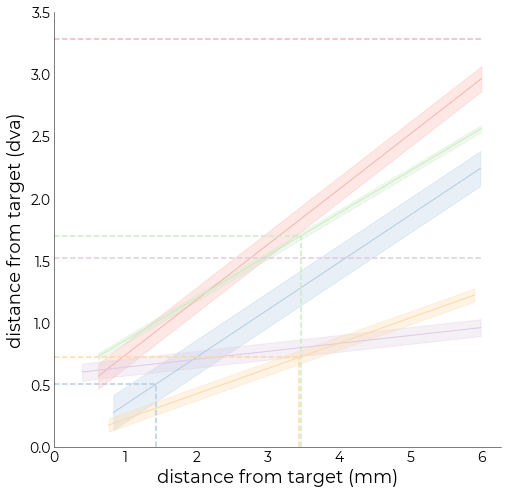

In [71]:
fig,axs = plt.subplots(figsize=(8,8))
for sub_ix,sub in enumerate(subjects):
    tmp_df = utils.select_from_df(df_geo, expression=f"subject = {sub}")
    
    # get subject-specific dataframe
    data = utils.select_from_df(df_geo, expression=f"subject = {sub}").sort_values("d_mm")

    # and depths
    mm = data["d_mm"].values
    dva = data["d_prf"].values

    # throw all subjects in CurveFitter
    cf = fitting.CurveFitter(
        dva, 
        x=mm,
        order=1, 
        verbose=False)

    # plot fit
    plotting.LazyPlot(
        cf.y_pred,
        xx=mm,
        axs=axs,
        error=cf.ci,
        color=sub_colors[sub_ix],
        x_label="distance from target (mm)",
        y_label="distance from target (dva)",
        y_lim=[0,3.5])

    # fetch distance target with line pRF
    line_dist = df_dist.loc[df_dist["name"] == "line avg"].loc[df_dist["subject"] == sub]["distance"].values[0]
    try:
        idx = np.argwhere(np.diff(np.sign(np.full_like(cf.x_pred_upsampled,line_dist) - cf.y_pred_upsampled))).flatten()[0]
        vline = True
    except:
        idx = cf.x_pred_upsampled.shape[-1]-1
        vline = False
    
    if vline:
        axs.axvline(x=cf.x_pred_upsampled[idx], ymax=line_dist/axs.get_ylim()[-1], color=sub_colors[sub_ix], ls="--")
    axs.axhline(y=line_dist, xmax=cf.x_pred_upsampled[idx]/axs.get_xlim()[-1], color=sub_colors[sub_ix], ls="--")

fname = opj(fig_dir, f"sub-all_model-{model}_desc-distance_single")

for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

## Normalized HRFs

Below, the HRFs per subject across depth are plotted. The HRFs are normalized to their own maximum amplitude

In [132]:
# # length of HRF window
# hrf_length_s = 40
# hrf_length_tr = int(hrf_length_s/0.105)

# # stimulus duration
# stim_dur_s = 1
# stim_dur_tr = int(stim_dur_s/0.105)

# normalize = False
# hrf_design = np.zeros(())
# hrfs = []
# for ix,sub in enumerate(subjects):

#     print(f"Dealing with {sub}")

#     sub_hrfs = []
#     fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
#     pars = fit_obj.norm_iter.copy()

#     # center pRF on origin
#     pars[:,:2] = 0

#     # pars the average line-pRF parameters into sizeresponse class
#     avg_pars = full_dict[sub]["lines"]["native"]["avg"].norm_iter.copy()
#     SR_ = prf.SizeResponse(fit_obj.prf_stim, avg_pars)

#     # find preferred stimulus size
#     print(f" searching preferred stimulus size")
#     ix, pref_stim2 = SR_.find_pref_size(size=avg_pars[0,2])
#     pref_stim2 = utils.resample2d(pref_stim2, 270)

#     # create design matrix
#     print(f" create design matrix")
#     hrf_dm = np.zeros((pref_stim2.shape[0],pref_stim2.shape[0],hrf_length_tr))
#     hrf_dm[...,stim_dur_tr:stim_dur_tr+stim_dur_tr] = np.tile(pref_stim2[...,np.newaxis],stim_dur_tr)

#     # load in design matrix & parameters
#     print(" initialize pRFmodelFitting-class")
#     hrf_obj = prf.pRFmodelFitting(
#         None,
#         design_matrix=hrf_dm,
#         TR=0.105,
#         screen_distance_cm=196,
#         verbose=False
#     )

#     hrf_obj.load_params(pars, model="norm", stage="iter")

#     # loop through voxel parameters
#     print(" fetch voxel-specific response to design matrix")
#     for ii in range(pars.shape[0]):
        
#         # get the HRF prediction
#         _,_,_,hrf = hrf_obj.plot_vox(
#             vox_nr=ii,
#             model="norm",
#             make_figure=False)

#         # normalize to its own maximum
#         if normalize:
#             hrf /= hrf.max()

#         # create time axis
#         xx = list(np.arange(0,hrf.shape[0])*fit_obj.TR)

#         # create dataframe
#         df_hrf = pd.DataFrame(hrf, columns=["hrf"])
#         df_hrf["subject"],df_hrf["t"],df_hrf["depth"] = sub,xx,ii

#         sub_hrfs.append(pd.DataFrame(df_hrf))
    
#     # append subject-specific HRFs
#     hrfs.append(pd.concat(sub_hrfs))

# print("Done")
# # concatenate into single dataframe
# hrf_df = pd.concat(hrfs).set_index(["subject","t","depth"])
# hrf_df


In [135]:
fit_obj.norm_iter.shape


(6, 12)

In [141]:
# length of HRF window
hrf_length_s = 40
hrf_length_tr = int(hrf_length_s/0.105)

# stimulus duration
stim_dur_s = 1
stim_dur_tr = int(stim_dur_s/0.105)

normalize = False
hrf_design = np.zeros(())
hrfs = []
for ix,sub in enumerate(subjects):

    print(f"Dealing with {sub}")

    sub_hrfs = []
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
    pars = fit_obj.norm_iter.copy()

    # loop through voxel parameters
    for ii in range(pars.shape[0]):
        
        # get the HRF prediction
        _,_,_,hrf = fit_obj.plot_vox(
            vox_nr=ii,
            model="norm",
            make_figure=False)
        
        # fetch first peak
        hrf = hrf[190:500,...]
        
        # create time axis
        xx = list(np.arange(0,hrf.shape[0])*fit_obj.TR)

        # create dataframe
        df_hrf = pd.DataFrame(hrf, columns=["hrf"])
        df_hrf["subject"],df_hrf["t"],df_hrf["depth"] = sub,xx,ii

        sub_hrfs.append(pd.DataFrame(df_hrf))
    
    # append subject-specific HRFs
    hrfs.append(pd.concat(sub_hrfs))

print("Done")
# concatenate into single dataframe
hrf_df = pd.concat(hrfs).set_index(["subject","t","depth"])
hrf_df


Dealing with sub-001
Dealing with sub-002
Dealing with sub-003
Dealing with sub-007
Dealing with sub-008
Done


hrf
subject t      depth              
sub-001 0.000  0      1.473718e-16
        0.105  0      7.368591e-17
        0.210  0     -4.993209e-10
        0.315  0     -1.421890e-08
        0.420  0     -9.809595e-08
...                            ...
sub-008 32.025 5     -3.263573e-03
        32.130 5     -2.430307e-03
        32.235 5     -1.492085e-03
        32.340 5     -4.333618e-04
        32.445 5      7.624297e-04

[11470 rows x 1 columns]

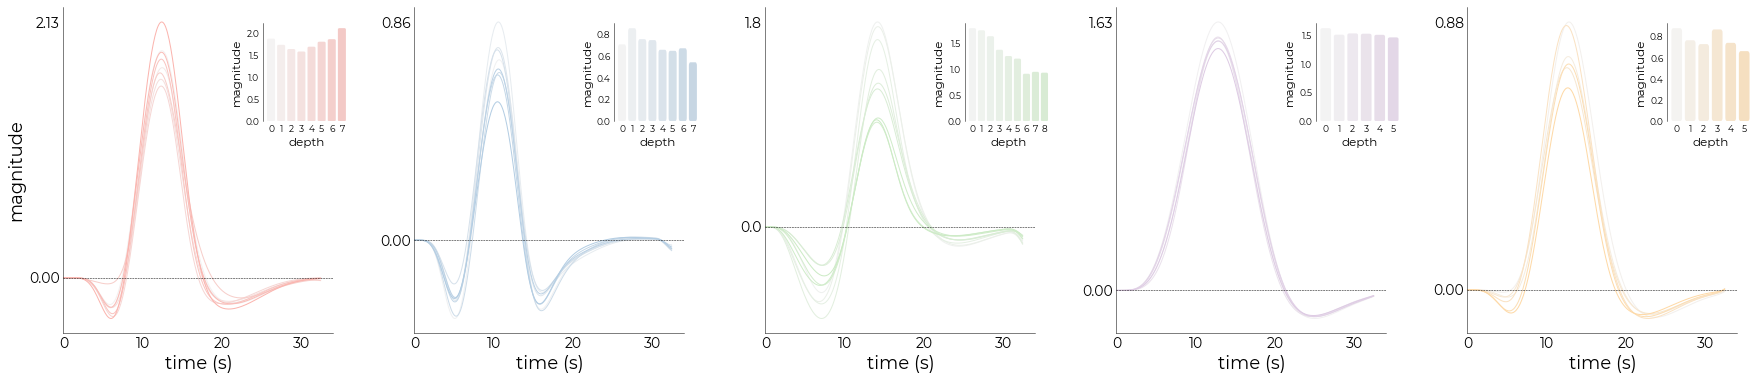

In [190]:
fig,axs = plt.subplots(ncols=len(dict_data),figsize=(6*len(dict_data),6), gridspec_kw={'wspace': 0.3})

plot_mag = True
plot_ttp = True
plot_fwhm = False

cmap = "viridis"
for ix,sub in enumerate(subjects):
    
    # get the pRF-object containing estimates across depth
    if "ribbon" in list(full_dict[sub]["lines"]["native"].keys()):
        
        fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

        # get subject-specific HRFs from HRF-dataframe  
        sub_hrf = utils.select_from_df(hrf_df, expression=f"subject = {sub}")

        # parse them into list depending on the number of voxels in estimates
        hrf_list = [utils.select_from_df(sub_hrf, expression=f"depth = {ii}")['hrf'].values for ii in range(fit_obj.norm_iter.shape[0])]

        # get subject specific color palette
        colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", len(hrf_list))
        y_ticks = None
        trim_left = False
        if ix == 0:
            if normalize:
                trim_left = True

            y_lbl = "magnitude"
        else:
            y_lbl = None

        # create time axis
        time_axis = list(np.arange(0,hrf_list[0].shape[0])*fit_obj.TR)

        # plot
        y_ticks = [0,round(np.amax(np.array(hrf_list)),2)]
        plotting.LazyPlot(
            hrf_list,
            axs=axs[ix],
            xx=time_axis,
            x_label="time (s)",
            y_label=y_lbl,
            cmap=colors,
            # x_lim=[0,25],
            # x_ticks=np.arange(0,30,5),
            y_ticks=y_ticks,
            add_hline=0,
            trim_left=trim_left
        )

        # # add annotation where stim was ON; timings where the same across subjects/depths so doesn't matter which hrf_dm we use here
        # stim_tp = np.where((np.sum(hrf_dm, axis=(0, 1)) != 0))[0]
        # axs[ix].axvspan(time_axis[stim_tp[0]],time_axis[stim_tp[-1]], color="#cccccc", alpha=0.5) #, ymin=0, ymax=0.05)
        
        # add time-to-peak across the ribbon as inset-axis
        tcs = np.array(hrf_list)
        peak_positions = (np.argmax(tcs, axis=1)/tcs.shape[-1])*xx[-1]

        # FWHM
        fwhm_objs = []
        for hrf in hrf_list:
            fwhm_objs.append(fitting.FWHM(time_axis, hrf))

        y_fwhm = np.array([i.fwhm for i in fwhm_objs])
        if plot_mag or plot_ttp or plot_fwhm:
            ax2 = axs[ix].inset_axes([0.75, 0.65, 0.3, 0.3])

        # get magnitudes
        mag = np.array([np.amax(i) for i in hrf_list])
        
        # decide plot properties depending on which type to put on the inset axis
        if plot_mag:
            plot_ttp = False
            plot_fwhm = False
            y_ax = mag
            ori = "v"
            y_lab = "magnitude"
            x_lab = "depth"

        if plot_ttp:
            plot_fwhm = False
            y_ax = peak_positions
            ori = "h"
            y_lab = "depth"
            x_lab = "time-to-peak (s)"

        if plot_fwhm:
            y_ax = y_fwhm
            ori = "v"
            y_lab = "FWHM"
            x_lab = "depth"            

        plotting.LazyBar(
            x=np.arange(0,len(hrf_list)),
            y=y_ax,
            axs=ax2,
            label_size=9,
            font_size=12,
            palette=colors,
            sns_ori=ori,
            add_labels=True,
            y_label2=y_lab,
            x_label2=x_lab,
            alpha=0.8,
            fancy=True,
            sns_offset=3,
            trim_bottom=True)            

fname = opj(fig_dir, f"sub-all_model-{model}_desc-first_bar")
if normalize:
    fname = f"{fname}_norm"

for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

## FWHM of normalization model

In [14]:
tiny_dm = np.zeros((500,500,500))
for ii in range(tiny_dm.shape[-1]):
    tiny_dm[250,ii,ii] = 1
    

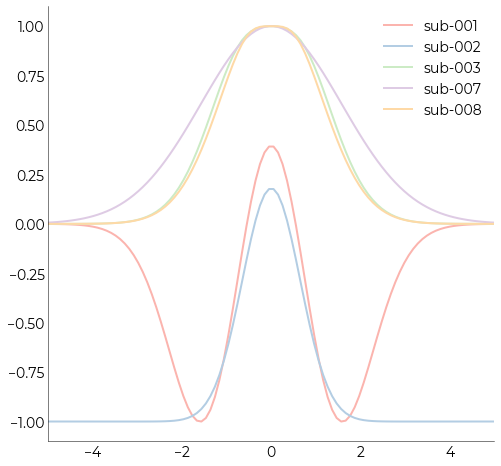

In [48]:
from pRFline import rf

fig,axs= plt.subplots(figsize=(8,8))
for sub_ix,sub in enumerate(subjects):
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
    pars = fit_obj.norm_iter.copy()
    pars[:,:2] = 0

    prf_info = rf.DnPrfInfo(
        np.array([pars[0,0]]),
        np.array([pars[0,2]]),
        np.array([pars[0,5]]),
        np.array([pars[0,3]]),
        np.array([pars[0,7]]),
        np.array([pars[0,5]]),
        np.array([pars[0,8]]),
        n_pix=100
    )

    prf_info.return_pt_profile()
    plotting.LazyPlot(
        prf_info.pt_resp.T,
        axs=axs,
        color=sub_colors[sub_ix],
        xx=prf_info.x_grid,
        figsize=(8,8),
        line_width=2,
        x_lim=[-5,5],
        labels=[sub]
    )

In [ ]:
fwhms = []
for ix,sub in enumerate(subjects):

    print(f"Dealing with {sub}")

    fwhm_subj = []
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
    pars = fit_obj.norm_iter.copy()

    # center pRF on origin
    pars[:,:2] = 0

    # load in design matrix & parameters
    print(" initialize pRFmodelFitting-class")
    fwhm_obj = prf.pRFmodelFitting(
        None,
        design_matrix=tiny_dm,
        TR=0.105,
        screen_distance_cm=196,
        verbose=False
    )

    fwhm_obj.load_params(pars, model="norm", stage="iter")

    # loop through voxel parameters
    print(" fetch voxel-specific response to design matrix")
    for ii in range(pars.shape[0]):
        
        # get the HRF prediction
        _,_,_,resp = fwhm_obj.plot_vox(
            vox_nr=ii,
            model="norm",
            make_figure=False)

        # normalize to its own maximum
        if normalize:
            resp /= resp.max()

        

        # create dataframe
        df_hrf = pd.DataFrame(hrf, columns=["hrf"])
        df_hrf["subject"],df_hrf["t"],df_hrf["depth"] = sub,xx,ii

        sub_hrfs.append(pd.DataFrame(df_hrf))
    
    # append subject-specific HRFs
    hrfs.append(pd.concat(sub_hrfs))    

## Parameters across depth

Here I plot the z-scored parameters across depth

### bar representation

In [16]:
# initialize parameter df
params_depth =  []

for ix,sub in enumerate(subjects):

    # initialize subject specific parameter df
    sub_hrfs = []

    # get the pRF-object containing estimates across depth
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

    # parse normalization parameters to dataframe
    df = prf.SizeResponse.parameters_to_df(fit_obj.norm_iter)

    # get numerical colums for applying z-score. x/y/baselines will be NaN because they're all zero anyway
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols].apply(stats.zscore)
    
    # append depth indexer
    df["subject"],df["depth"] = sub,np.arange(0,df.shape[0])
    params_depth.append(df)
    
# concatenate into single dataframe
params_depth = pd.concat(params_depth)
params_depth = params_depth.set_index(["subject","depth"])
params_depth.head()

x   y  prf_size  prf_ampl  bold_bsl  neur_bsl  surr_ampl  \
subject depth                                                              
sub-001 0     NaN NaN -0.289508 -0.220417       NaN -0.442587  -0.866949   
        1     NaN NaN -2.050314 -0.358276       NaN -0.927355   0.765810   
        2     NaN NaN -0.796968 -0.977550       NaN -0.860534  -1.107885   
        3     NaN NaN -0.176409 -0.461753       NaN -0.499865   0.389071   
        4     NaN NaN  0.655882  1.082124       NaN  1.421649   0.185734   

               surr_size  surr_bsl         A         B         C         D  \
subject depth                                                                
sub-001 0      -0.618992       NaN -0.220417 -0.442587 -0.866949 -0.488015   
        1       2.491875       NaN -0.358276 -0.927355  0.765810 -0.530912   
        2      -0.730497       NaN -0.977550 -0.860534 -1.107885 -0.526298   
        3      -0.440496       NaN -0.461753 -0.499865  0.389071 -0.153996   
        4      -0.381705       NaN  1.082124  1.421649  0.185734 -0.089396   

               ratio (B/D)        r2  size ratio  suppression index  ecc  \
subject depth                                                              
sub-001 0         0.602092 -0.177408   -0.463899          -0.531044  NaN   
        1        -1.218336 -1.347084    2.610823           2.545544  NaN   
        2         1.027403 -1.405042   -0.466681          -0.540155  NaN   
        3        -1.037101 -0.673734   -0.352667          -0.208539  NaN   
        4        -0.358932  1.203474   -0.439719          -0.481763  NaN   

               polar  
subject depth         
sub-001 0        NaN  
        1        NaN  
        2        NaN  
        3        NaN  
        4        NaN

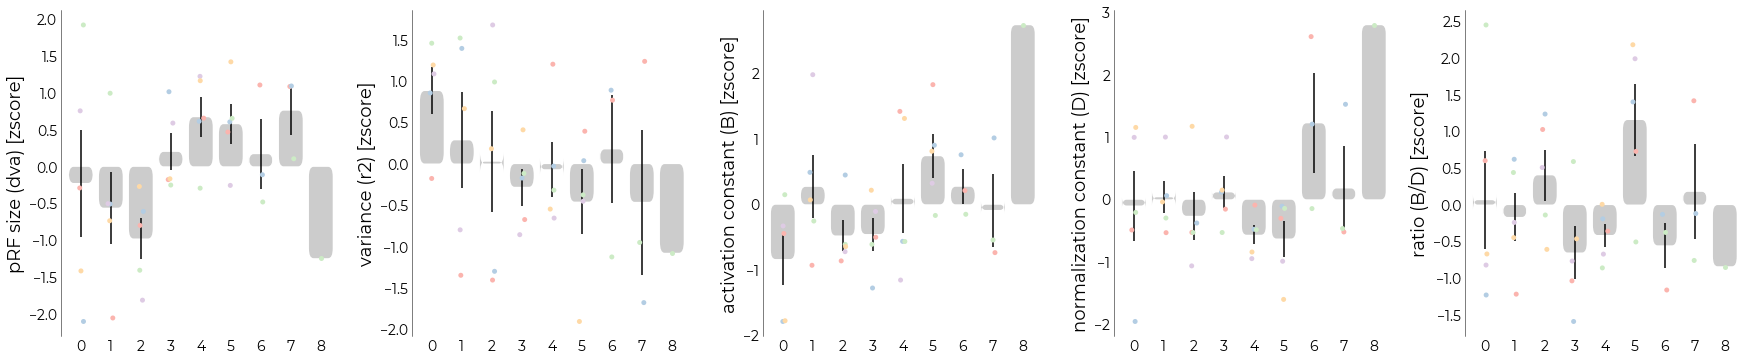

In [17]:
# make list of parameters to include; should strings that are present as column names in dataframe above
include = ["prf_size","r2","B","D"]

# initialize figure
fig = plt.figure(figsize=(len(include)*6,6))
gs = fig.add_gridspec(ncols=len(include), wspace=0.3)

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = fig.add_subplot(gs[par_ix])

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "suppression (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "compression (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    # plot; fancy=True means rounding of the bars
    plotting.LazyBar(
        data=params_depth.reset_index(),
        x="depth",
        y=par,
        sns_ori="v",
        axs=ax,
        color="#cccccc",
        sns_offset=5,
        add_points=True,
        add_labels=True,
        y_label2=x_label,
        points_cmap=cmap_subj,
        points_hue="subject",
        fancy=True,
        fancy_aspect=0.9,
        trim_bottom=True)

# for ext in ['png','svg']:
#     fig.savefig(
#         opj(fig_dir, f"sub-all_model-{model}_desc-depth_pars.{ext}"),
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )                    

### scatter representation

In [142]:
# initialize parameter df
params_depth_sc =  []

for ix,sub in enumerate(subjects):

    # initialize subject specific parameter df
    sub_hrfs = []

    # get the pRF-object containing estimates across depth
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

    # parse normalization parameters to dataframe
    df = prf.SizeResponse.parameters_to_df(fit_obj.norm_iter)

    # get numerical colums for applying z-score. x/y/baselines will be NaN because they're all zero anyway
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols].apply(stats.zscore)
    
    # append depth indexer
    df["subject"],df["depth"] = sub,np.arange(0,df.shape[0])/df.shape[0]*100
    params_depth_sc.append(df)
    
# concatenate into single dataframe
params_depth_sc = pd.concat(params_depth_sc)
params_depth_sc = params_depth_sc.set_index(["subject","depth"])
params_depth_sc.head()

x   y  prf_size  prf_ampl  bold_bsl  neur_bsl  surr_ampl  \
subject depth                                                              
sub-001 0.0   NaN NaN -0.100336 -0.578802       NaN -0.650291  -0.659452   
        12.5  NaN NaN  0.302861 -0.828986       NaN -0.725997  -0.903768   
        25.0  NaN NaN  0.216146  0.242144       NaN  0.191162   2.185221   
        37.5  NaN NaN  0.109568 -0.628795       NaN -0.585099  -0.672933   
        50.0  NaN NaN -2.349150 -0.551123       NaN -0.831165  -0.176598   

               surr_size  surr_bsl         A         B         C         D  \
subject depth                                                                
sub-001 0.0    -0.522724       NaN -0.578802 -0.650291 -0.659452 -0.544284   
        12.5   -0.498246       NaN -0.828986 -0.725997 -0.903768 -0.585602   
        25.0    0.093515       NaN  0.242144  0.191162  2.185221  2.438166   
        37.5   -0.480546       NaN -0.628795 -0.585099 -0.672933 -0.521793   
        50.0    2.590961       NaN -0.551123 -0.831165 -0.176598 -0.585341   

               ratio (B/D)        r2  size ratio  suppression index  ecc  \
subject depth                                                              
sub-001 0.0      -0.152951  1.367269   -0.437725          -0.460876  NaN   
        12.5      2.245301  1.366836   -0.463743          -0.564176  NaN   
        25.0     -0.986950  0.188529   -0.021234           0.308083  NaN   
        37.5     -0.213801 -0.353133   -0.429745          -0.448887  NaN   
        50.0     -1.066674 -1.229403    2.620881           2.553421  NaN   

               polar  
subject depth         
sub-001 0.0      NaN  
        12.5     NaN  
        25.0     NaN  
        37.5     NaN  
        50.0     NaN

In [19]:
# fig,axs = plt.subplots(figsize=(8,8))
# fit_order = 1
# par = "r2"
# for sub_ix,sub in enumerate(subjects):

#     # get subject-specific dataframe
#     data = utils.select_from_df(params_depth_sc, expression=f"subject = {sub}")

#     # and depths
#     depths = data.reset_index()["depth"].values

#     for ix,dep in enumerate(depths):
#         axs.plot(dep,data[par].iloc[ix], "o", color=sub_colors[sub_ix])

# # throw all subjects in CurveFitter
# yy = params_depth_sc.sort_values(['depth','subject'])[par].values
# cf = fitting.CurveFitter(
#     yy, 
#     x=np.linspace(0,100,yy.shape[0]),
#     order=1, 
#     verbose=False)

# # plot fit
# plotting.LazyPlot(
#     cf.y_pred,
#     xx=np.linspace(0,100,yy.shape[0]),
#     axs=axs,
#     error=cf.ci,
#     color="#cccccc",
#     x_label="depth (%)",
#     x_ticks=[0,50,100],
#     title=f"{par}",
#     y_label="variance explained")


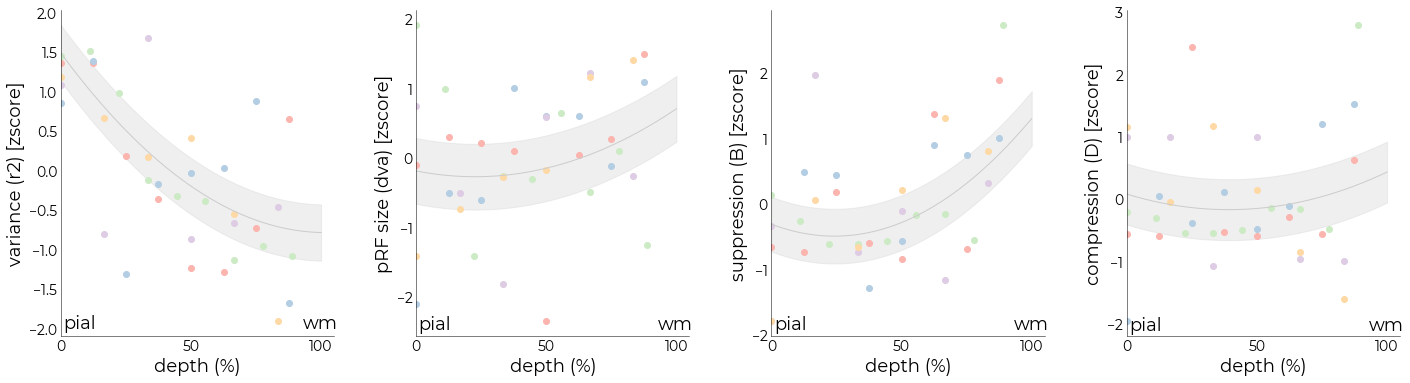

In [197]:
# make list of parameters to include; should strings that are present as column names in dataframe above
include = ["r2","prf_size","B","D"]
fit_order = 2

# initialize figure
fig = plt.figure(figsize=(24,6))
gs = fig.add_gridspec(ncols=len(include), wspace=0.3)

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = fig.add_subplot(gs[par_ix])

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "suppression (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "compression (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    for sub_ix,sub in enumerate(subjects):

        # get subject-specific dataframe
        data = utils.select_from_df(params_depth_sc, expression=f"subject = {sub}")

        # and depths
        depths = data.reset_index()["depth"].values

        for ix,dep in enumerate(depths):
            ax.plot(dep,data[par].iloc[ix], "o", color=sub_colors[sub_ix])

    # throw all subjects in CurveFitter
    if not isinstance(fit_order, int):
        if len(fit_order) != len(subjects):
            raise ValueError(f"Expected a list of length {len(include)} for fit orders, not {len(fit_order)}. Please specify an integer representing the fit order for all elements in {include} or a list of fit orders for each parameter")

        order = fit_order[par_ix]
    else:
        order = fit_order

    yy = params_depth_sc.sort_values(['depth','subject'])[par].values
    cf = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=order, 
        verbose=False)

    # plot fit
    pl = plotting.LazyPlot(
        cf.y_pred_upsampled,
        xx=cf.x_pred_upsampled,
        axs=ax,
        error=cf.ci_upsampled,
        color="#cccccc",
        x_label="depth (%)",
        x_ticks=[0,50,100],
        y_label=x_label)

    # pial
    ax.annotate(
        "pial", 
        (1,ax.get_ylim()[0]+0.1), 
        fontsize=pl.font_size)

    # wm
    ax.annotate(
        "wm", 
        (93,ax.get_ylim()[0]+0.1), 
        fontsize=pl.font_size)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_pars_scatter2")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

## Full figure

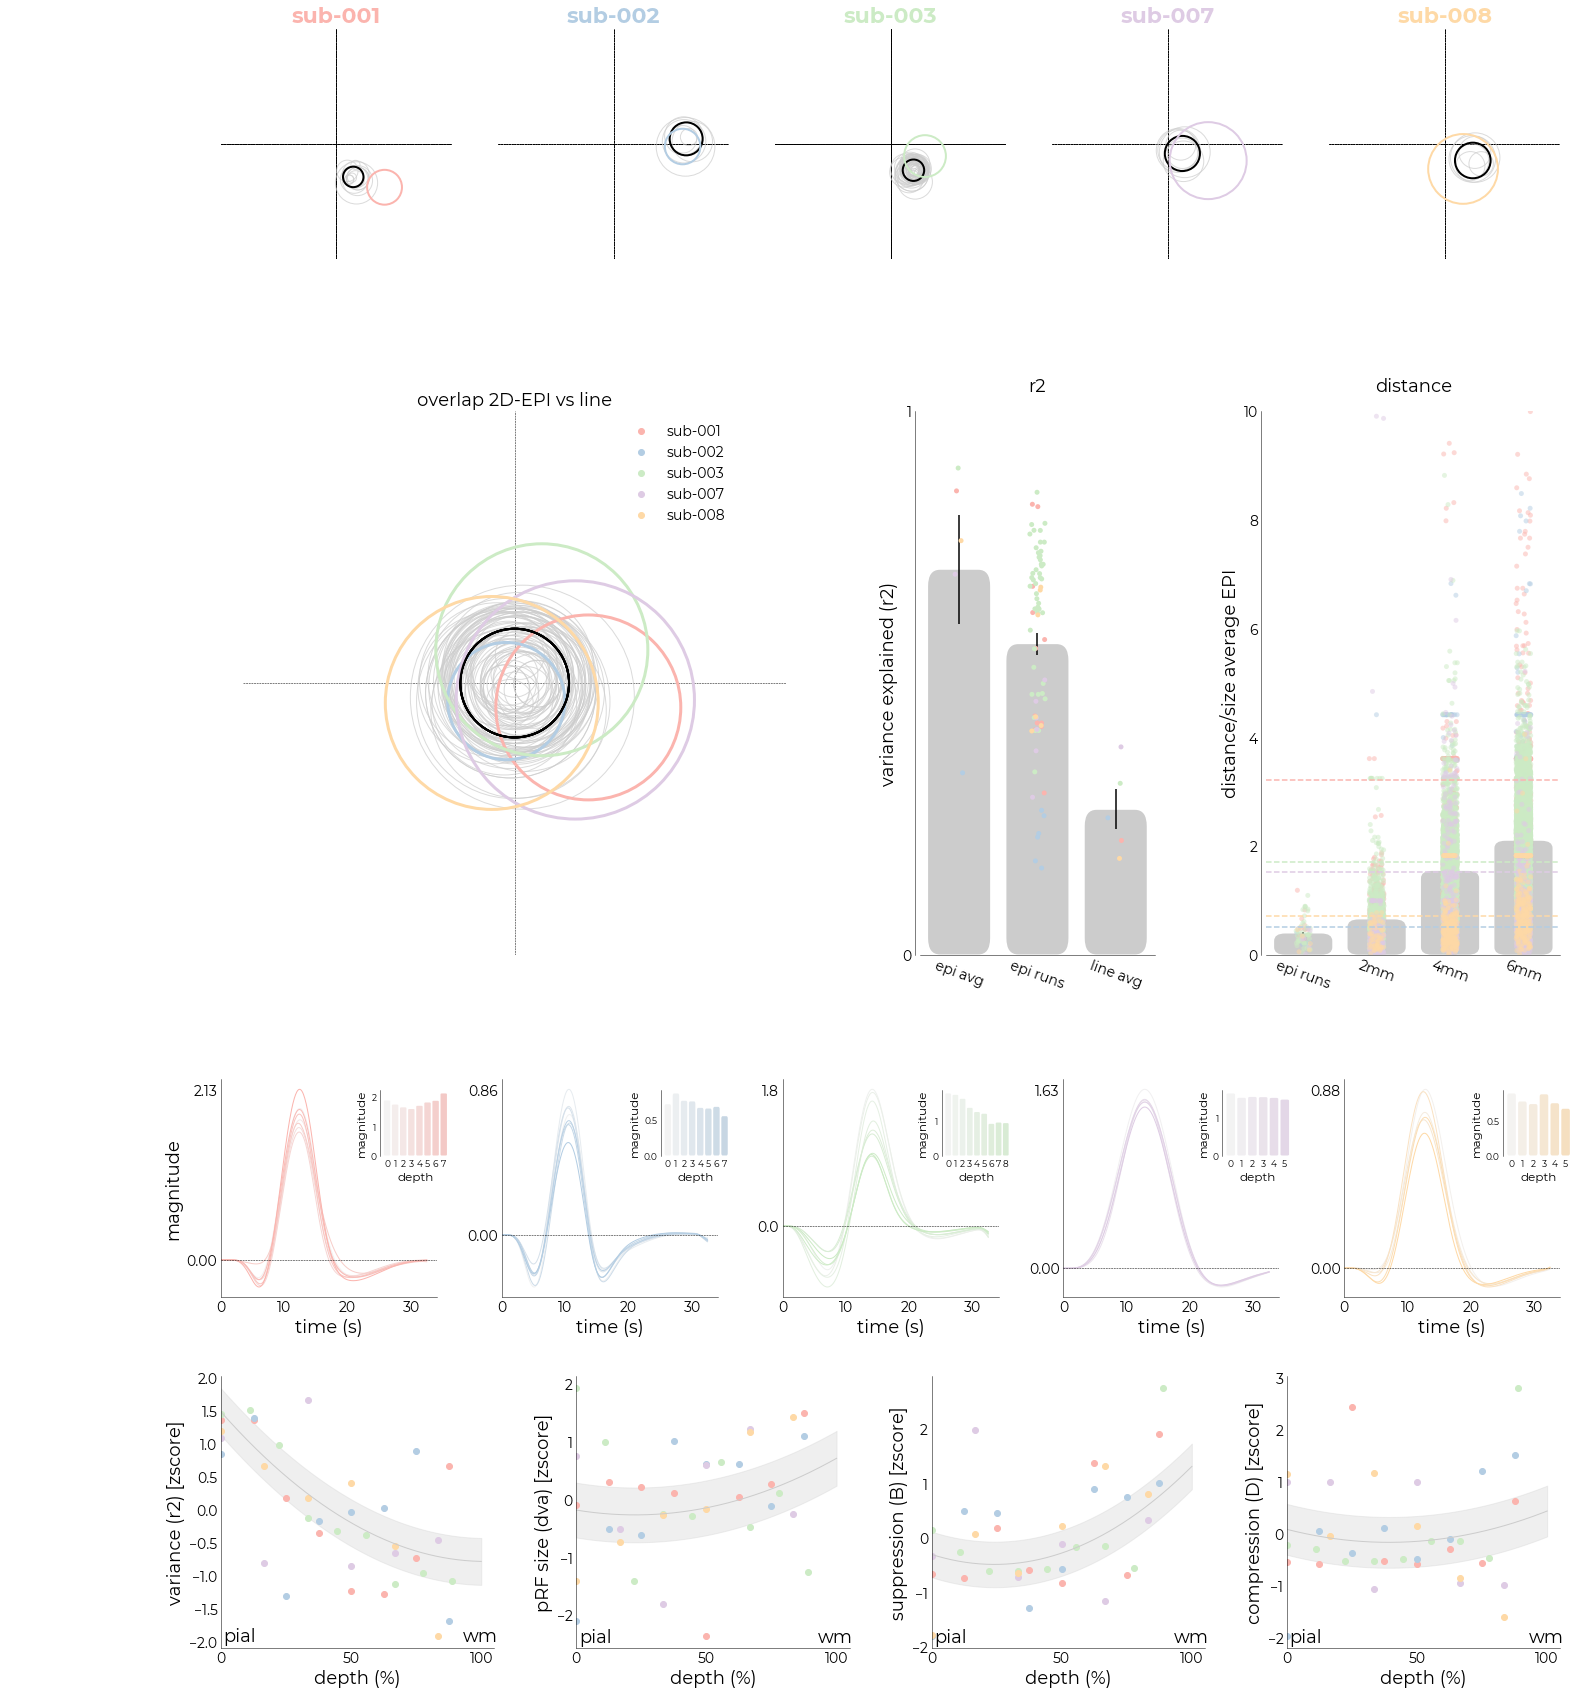

In [198]:
# figure settings
fig = plt.figure(figsize=(24,24))
subfigs = fig.subfigures(nrows=4, height_ratios=[0.5,1,0.4,0.5])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=3, 
    gridspec_kw={
        'width_ratios': [1,0.4,0.5], 
        'wspace': 0.3})

# axis for pRF overlap plot
axs = axs_avg[0]

colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(full_dict.keys())
cmap_subj = "Pastel1"
sub_colors = sns.color_palette(cmap_subj, len(subjects))

####################################################################################################
# pRF locations + distance plots
####################################################################################################

r2s, dist = {},{}
r2s["subject"], r2s["r2"], r2s["acq"], r2s["name"] = [],[],[],[]
dist["subject"], dist["distance"], dist["acq"], dist["name"] = [],[],[],[]

# if fit_nbr == True, target vertex is last row
est_idx = 0

for ix,sub in enumerate(subjects):

    ax_ = axs_subj[ix]

    for fit in full_dict[sub]['wb']:
        
        # find index of target 
        est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]
        
        if fit != "avg":
            # get parameters from individual runs
            pars,_,_,_ = full_dict[sub]['wb'][fit].plot_vox(
                vox_nr=est_idx,
                model=model,
                stage='iter',
                make_figure=False
            )

            if pars[-1] != 0:
                # get parameters from average
                avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
                    vox_nr=est_idx,
                    model=model,
                    stage='iter',
                    make_figure=False
                )

                # express distance as distance/size
                dist_dva = prf.distance_centers(avg_pars,pars)/avg_pars[2]
                dist["distance"].append(dist_dva)
                dist["subject"].append(sub)
                dist["name"].append("epi runs")
                dist["acq"].append(0)                

                # append r2 to dictionary
                r2s["r2"].append(pars[-1])
                r2s["subject"].append(sub)
                r2s["name"].append("epi runs")
                r2s["acq"].append(1)
                
            # get distance/size of neighbouring vertices
            if fit_nbr:
                nbr_pars = getattr(full_dict[sub]['wb'][fit], f"{model}_iter")
                for nbr in range(nbr_pars.shape[0]):
                    
                    # filter out target vertex
                    if full_dict[sub]["vertices"]["all"][nbr] != full_dict[sub]["vertices"]["target"]:

                        # get parameters from neighbours
                        nbr_estimates = nbr_pars[nbr,:]

                        # plot normalized neighbour
                        nbr_norm = prf.normalize_prf(avg_pars,nbr_estimates)

                        # find x/y of max pRF
                        center = (nbr_norm[0],nbr_norm[1])
                        circ_nbr = plt.Circle(
                            center,
                            nbr_norm[2],
                            ec="r",
                            fill=False,
                            alpha=0.15)
                        # axs.add_artist(circ_nbr)      
                        
                        if nbr in full_dict[sub]["vertices"]["2mm"]:
                            nn = "2mm"
                            ct = 1
                        elif nbr in full_dict[sub]["vertices"]["4mm"]:
                            nn = "4mm"
                            ct = 2
                        elif nbr in full_dict[sub]["vertices"]["6mm"]:
                            nn = "6mm"
                            ct = 3

                        dist_dva = prf.distance_centers(avg_pars,nbr_estimates)/avg_pars[2]
                        dist["distance"].append(dist_dva)
                        dist["subject"].append(sub)
                        dist["name"].append(nn)
                        dist["acq"].append(ct)                                  

        else:
            r2s["r2"].append(getattr(full_dict[sub]['wb']['avg'], f"{model}_iter")[est_idx,-1])
            r2s["subject"].append(sub)
            r2s["name"].append("epi avg")
            r2s["acq"].append(0)            

        if fit == 0 and ix == 0:

            # create visual field delineation, plot on subject specific axis & average
            plotting.LazyPRF(
                np.zeros((500,500)), 
                [-5,5],
                ax=axs,
                cross_color="k",
                edge_color=None,
                shrink_factor=0.9,
                cmap=cmap1,
                vf_only=True)

        # draw empty visual field for subject
        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax_,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)                

        if fit != "avg":
            # plot normalized pRF
            run_norm = prf.normalize_prf(avg_pars,pars)
            
            # find x/y of max pRF
            center = (run_norm[0],run_norm[1])
            circ2 = plt.Circle(
                center,
                run_norm[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)
        
            axs.add_artist(circ2)

            # add non-normalized to subject specific axis
            circ_run_subj = plt.Circle(
                (pars[0],pars[1]),
                pars[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)

            ax_.add_artist(circ_run_subj)

line_avg_idx_dist = len(np.unique(dist["acq"]))            
for ix,sub in enumerate(subjects):

    #re-fetch the index of target vertex
    est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

    # get parameters from average
    avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
        vox_nr=est_idx,
        model=model,
        stage='iter',
        make_figure=False
    )

    circ_avg = plt.Circle(
        (0,0),
        1,
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    axs.add_artist(circ_avg)

    # add average line-scanning
    l_pars,_,_,_ = full_dict[sub]['lines']['native']["avg"].plot_vox(
        model=model,
        stage='iter',
        make_figure=False
    )

    # plot normalized pRF
    line_norm = prf.normalize_prf(avg_pars,l_pars)

    # find x/y of max pRF
    center = (line_norm[0],line_norm[1])
    circ3 = plt.Circle(
        center,
        line_norm[2],
        ec=sub_colors[ix],
        fill=False,
        lw=3)

    axs.add_artist(circ3)

    # add to subject specific axis
    sub_epi = plt.Circle(
        (avg_pars[0],avg_pars[1]),
        avg_pars[2],
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    sub_line = plt.Circle(
        (l_pars[0],l_pars[1]),
        l_pars[2],
        ec=sub_colors[ix],
        fill=False,
        lw=2)

    axs_subj[ix].add_artist(sub_epi)    
    axs_subj[ix].add_artist(sub_line)    

    # axs.annotate(sub, xy=center, fontsize=12, ha="center")
    axs_subj[ix].set_title(sub, fontsize=22, color=sub_colors[ix], fontweight="bold")
    axs.set_title("overlap 2D-EPI vs line", fontsize=18)
    
    # append to r2 array
    avg_idx = 2
    if downsample:
        l_ds_pars,_,_,_ = full_dict[sub]['lines']['ds'].plot_vox(
            model=model,
            stage='iter',
            make_figure=False
        )

        avg_idx = 3
        r2s["r2"].append(l_ds_pars[-1])
        r2s["subject"].append(sub)
        r2s["name"].append("line ds")
        r2s["acq"].append(2)        

    r2s["r2"].append(l_pars[-1])
    r2s["subject"].append(sub)
    r2s["name"].append("line avg")
    r2s["acq"].append(avg_idx)

    # append distance
    line_dist = prf.distance_centers(avg_pars, l_pars)/avg_pars[2]
    dist["distance"].append(line_dist)
    dist["subject"].append(sub)
    dist["name"].append("line avg")
    dist["acq"].append(line_avg_idx_dist)

# make dataframe
df_r2 = pd.DataFrame(r2s)
df_dist = pd.DataFrame(dist)

# enforce float
df_r2["r2"] = df_r2["r2"].astype(float)
df_dist["distance"] = df_dist["distance"].astype(float)
df_r2.head()

r2_axs = axs_avg[1]
dist_axs = axs_avg[2]

plotting.LazyBar(
    data=df_r2.sort_values(['acq','subject']),
    x="name",
    y="r2",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=r2_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    points_cmap=cmap_subj,
    points_hue="subject",    
    y_label2="variance explained (r2)",
    title2="r2",
    ticks=[0,1],
    lim=[0,1],
    fancy=True,
    trim_bottom=True
)

plotting.LazyBar(
    data=utils.select_from_df(df_dist, expression=f"acq != {line_avg_idx_dist}").sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=dist_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    bbox_to_anchor=(-1.8,1),
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
    trim_bottom=True,
    lim=[0,10]
)
for ix, sub in enumerate(subjects):
    line_dist = utils.select_from_df(df_dist, expression=(f"acq = {line_avg_idx_dist}", "&", f"subject = {sub}"))["distance"].values[0]
    dist_axs.axhline(line_dist, color=sub_colors[ix], ls="--", zorder=3)

# v1_axs = dist_axs.inset_axes([0.7, 0.7, 0.6, 0.6])
# im = imageio.imread(opj(design_dir, "sub-001", "sub-001_hemi-L_desc-V1_distances.png"))
# v1_axs.imshow(im[2000:,:2000,:])
# v1_axs.axis('off')

####################################################################################################
# HRFs
####################################################################################################
hrf_axs = subfigs[2].subplots(ncols=len(dict_data), gridspec_kw={'wspace': 0.3})

plot_mag = True
plot_ttp = True
plot_fwhm = False

cmap = "viridis"
for ix,sub in enumerate(subjects):
    
    # get the pRF-object containing estimates across depth
    if "ribbon" in list(full_dict[sub]["lines"]["native"].keys()):
        
        fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

        # get subject-specific HRFs from HRF-dataframe  
        sub_hrf = utils.select_from_df(hrf_df, expression=f"subject = {sub}")

        # parse them into list depending on the number of voxels in estimates
        hrf_list = [utils.select_from_df(sub_hrf, expression=f"depth = {ii}")['hrf'].values for ii in range(fit_obj.norm_iter.shape[0])]

        # get subject specific color palette
        colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", len(hrf_list))
        y_ticks = None
        trim_left = False
        if ix == 0:
            if normalize:
                trim_left = True

            y_lbl = "magnitude"
        else:
            y_lbl = None

        # create time axis
        time_axis = list(np.arange(0,hrf_list[0].shape[0])*fit_obj.TR)

        # plot
        y_ticks = [0,round(np.amax(np.array(hrf_list)),2)]
        plotting.LazyPlot(
            hrf_list,
            axs=hrf_axs[ix],
            xx=time_axis,
            x_label="time (s)",
            y_label=y_lbl,
            cmap=colors,
            # x_lim=[0,25],
            # x_ticks=np.arange(0,30,5),
            y_ticks=y_ticks,
            add_hline=0,
            trim_left=trim_left
        )

        # # add annotation where stim was ON; timings where the same across subjects/depths so doesn't matter which hrf_dm we use here
        # stim_tp = np.where((np.sum(hrf_dm, axis=(0, 1)) != 0))[0]
        # axs[ix].axvspan(time_axis[stim_tp[0]],time_axis[stim_tp[-1]], color="#cccccc", alpha=0.5) #, ymin=0, ymax=0.05)
        
        # add time-to-peak across the ribbon as inset-axis
        tcs = np.array(hrf_list)
        peak_positions = (np.argmax(tcs, axis=1)/tcs.shape[-1])*xx[-1]

        # FWHM
        fwhm_objs = []
        for hrf in hrf_list:
            fwhm_objs.append(fitting.FWHM(time_axis, hrf))

        y_fwhm = np.array([i.fwhm for i in fwhm_objs])
        if plot_mag or plot_ttp or plot_fwhm:
            ax2 = hrf_axs[ix].inset_axes([0.75, 0.65, 0.3, 0.3])

        # get magnitudes
        mag = np.array([np.amax(i) for i in hrf_list])
        
        # decide plot properties depending on which type to put on the inset axis
        if plot_mag:
            plot_ttp = False
            plot_fwhm = False
            y_ax = mag
            ori = "v"
            y_lab = "magnitude"
            x_lab = "depth"

        if plot_ttp:
            plot_fwhm = False
            y_ax = peak_positions
            ori = "h"
            y_lab = "depth"
            x_lab = "time-to-peak (s)"

        if plot_fwhm:
            y_ax = y_fwhm
            ori = "v"
            y_lab = "FWHM"
            x_lab = "depth"            

        plotting.LazyBar(
            x=np.arange(0,len(hrf_list)),
            y=y_ax,
            axs=ax2,
            label_size=9,
            font_size=12,
            palette=colors,
            sns_ori=ori,
            add_labels=True,
            y_label2=y_lab,
            x_label2=x_lab,
            alpha=0.8,
            fancy=True,
            sns_offset=3,
            trim_bottom=True)
            
####################################################################################################
# pRF estimates across depth
####################################################################################################
include = ["r2","prf_size","B","D"]

# initialize figure
pars_axs = subfigs[3].subplots(ncols=len(include), gridspec_kw={'wspace': 0.3})

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = pars_axs[par_ix]

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "suppression (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "compression (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    for sub_ix,sub in enumerate(subjects):

        # get subject-specific dataframe
        data = utils.select_from_df(params_depth_sc, expression=f"subject = {sub}")

        # and depths
        depths = data.reset_index()["depth"].values

        for ix,dep in enumerate(depths):
            ax.plot(dep,data[par].iloc[ix], "o", color=sub_colors[sub_ix])

    # throw all subjects in CurveFitter
    if not isinstance(fit_order, int):
        if len(fit_order) != len(subjects):
            raise ValueError(f"Expected a list of length {len(include)} for fit orders, not {len(fit_order)}. Please specify an integer representing the fit order for all elements in {include} or a list of fit orders for each parameter")

        order = fit_order[par_ix]
    else:
        order = fit_order

    yy = params_depth_sc.sort_values(['depth','subject'])[par].values
    cf = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=order, 
        verbose=False)

    # plot fit
    pl = plotting.LazyPlot(
        cf.y_pred_upsampled,
        xx=cf.x_pred_upsampled,
        axs=ax,
        error=cf.ci_upsampled,
        color="#cccccc",
        x_label="depth (%)",
        x_ticks=[0,50,100],
        y_label=x_label)

    # pial
    ax.annotate(
        "pial", 
        (1,ax.get_ylim()[0]+0.1), 
        fontsize=pl.font_size)

    # wm
    ax.annotate(
        "wm", 
        (93,ax.get_ylim()[0]+0.1), 
        fontsize=pl.font_size)
        
fname = opj(fig_dir, f"sub-all_model-{model}_desc-full_figure")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

In [82]:
df_dist.to_csv(opj(design_dir, "distance.csv"))
df_r2.to_csv(opj(design_dir, "r2.csv"))
hrf_df.to_csv(opj(design_dir, "hrf.csv"))

## Test significance bars

In [61]:
np.unique(dist['acq'])

array([0, 1, 2, 3, 4])

In [46]:
# from: https://stackoverflow.com/a/52333561
def barplot_annotate_brackets(
    num1, 
    num2, 
    data, 
    center, 
    height, 
    yerr=None, 
    dh=.05, 
    barh=.05, 
    fs=None, 
    maxasterix=None,
    axs=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    if not axs:
        import matplotlib.pyplot as plt
        cmd = plt
    else:
        cmd = axs

    cmd.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    cmd.text(*mid, text, **kwargs)

(-0.5, 1999.5, 1999.5, -0.5)

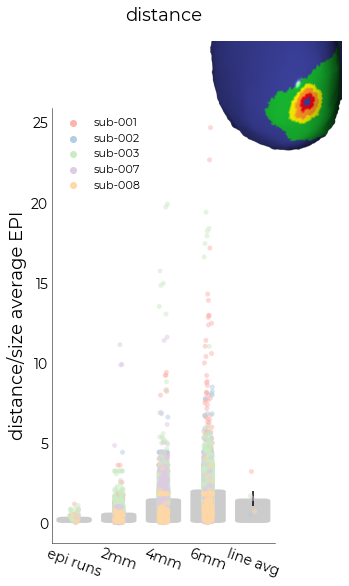

In [41]:
import imageio

fig,axs = plt.subplots(figsize=(4,8))

plotting.LazyBar(
    data=df_dist.sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    axs=axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    sns_rot=-20,
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
)

ax2 = axs.inset_axes([0.7, 0.7, 0.6, 0.6])
im = imageio.imread(opj(design_dir, "sub-001", "sub-001_hemi-L_desc-V1_distances.png"))
ax2.imshow(im[2000:,:2000,:])
ax2.axis('off')

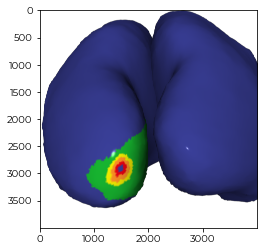

In [86]:

# ax2 = axs.inset_axes([0.75, 0.65, 0.3, 0.3])
im = imageio.imread(opj(design_dir, "sub-001", "sub-001_hemi-L_desc-V1_distances.png"))
plt.imshow(im)

In [67]:
test_df = df_dist.sort_values(['acq','subject']).copy()
df_dist.loc[df_dist["acq"] == 0]["distance"]

0        0.470809
170      0.827212
340      0.468933
510      0.364001
680      0.480772
           ...   
13051    0.344219
13172    0.091971
13293    0.464834
13414    0.209737
13535    0.507453
Name: distance, Length: 76, dtype: float64

In [71]:
fvalue,pvalue = stats.f_oneway(*[test_df.loc[test_df["acq"] == ii]["distance"] for ii in range(len(np.unique(test_df["acq"])))])

import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

lm = sfa.ols('distance ~ C(acq)', data=test_df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

               df        sum_sq     mean_sq           F  PR(>F)
C(acq)        4.0   2823.755035  705.938759  508.646191     0.0
Residual  13656.0  18952.859299    1.387878         NaN     NaN


## Timecourses

Here I plot the timecourses for the ribbon-voxels, as well as their individual fits

In [33]:
subjects

['sub-001', 'sub-002', 'sub-003', 'sub-007', 'sub-008']

In [34]:
for sub in subjects:
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
    fig = plt.figure(figsize=(24,6*fit_obj.norm_iter.shape[0]))
    subfigs = fig.subfigures(nrows=fit_obj.norm_iter.shape[0]+1, hspace=0.4)

    # plot voxel timecourses
    ax = subfigs[0].subplots()
    plotting.LazyPlot(
        [fit_obj.data[ii,:] for ii in range(fit_obj.norm_iter.shape[0])],
        axs=ax,
        labels=[f"depth {ii}" for ii in range(fit_obj.norm_iter.shape[0])],
        line_width=0.7,
        x_label="volumes",
        y_label="magnitude",
        add_hline=0,
        cmap="magma"
    )

    # plot fits
    for fit in range(fit_obj.norm_iter.shape[0]):
        axs = subfigs[fit+1].subplots(ncols=2, gridspec_kw={'width_ratios': [0.3,0.65]})

        fit_obj.plot_vox(
            vox_nr=fit,
            model=model,
            title=f"depth - {fit}; {[round(ii,2) for ii in fit_obj.norm_iter[fit,:]]}",
            axs=list(axs)
        )   

    plt.close(fig)
    for ext in ['png','svg']:
        fig.savefig(
            opj(fig_dir, sub, f"{sub}_model-{model}_desc-fits_depth.{ext}"),
            bbox_inches="tight",
            dpi=300,
            facecolor="white"
        )

In [32]:
fig_dir

'/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results'

## Other shenanigans

In [76]:
df_reg = []
subjects = list(dict_data.keys())
for subject in subjects:
    fname = opj(design_dir, subject, f"{subject}_hemi-L_desc-reg_accuracy.npy")
    if not os.path.exists(fname):
        print(f"{subject}: file doesn't exist. Run 'python accuracy.py -s {subject}'")
    else:
        acc = np.load(fname)

        tmp_df = pd.DataFrame(acc, columns=["euclidian"])
        tmp_df["subject"] = subject
        df_reg.append(tmp_df)

if len(df_reg) >= 1:
    df_reg = pd.concat(df_reg)
df_reg

,euclidian,subject
0,0.299179,sub-001
1,0.227381,sub-001
2,0.281064,sub-001
3,0.285535,sub-001
4,0.313322,sub-001
...,...,...
95,0.229491,sub-008
96,0.201639,sub-008
97,0.280678,sub-008
98,0.225827,sub-008


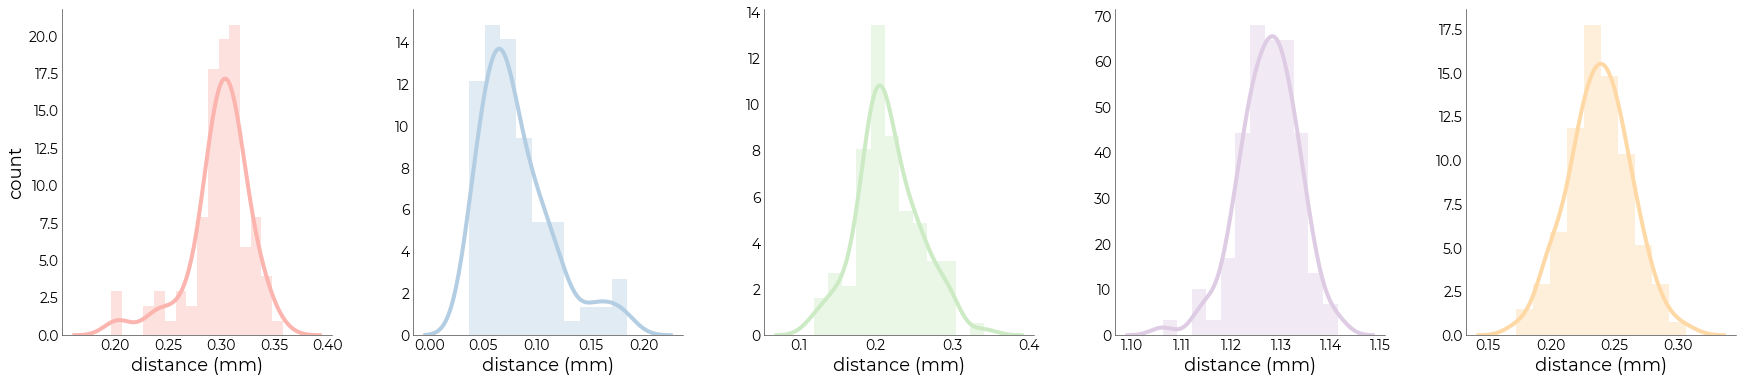

In [77]:
fig,axs = plt.subplots(ncols=len(subjects),figsize=(6*len(subjects),6), gridspec_kw={'wspace': 0.3})

fwhm_objs = []
for sub_ix,subject in enumerate(subjects):
    ax = axs[sub_ix]
    y_lbl = None
    if sub_ix == 0:
        y_lbl = "count"


    y_data = utils.select_from_df(df_reg, expression=f"subject = {subject}")['euclidian'].values
    plot = plotting.LazyHist(
        y_data,
        axs=ax,
        kde=True,
        hist=True,
        fill=False,
        y_label2=y_lbl,
        x_label2="distance (mm)",
        color=sub_colors[sub_ix],
        hist_kwargs={
            "alpha": 0.4
        },
        kde_kwargs={
            "linewidth": 4
        },
        return_obj=True
    )
    
    # get kde line
    fwhm_objs.append(fitting.FWHM(plot.kde[0],plot.kde[-1]))

fname = opj(fig_dir, f"sub-all_model-{model}_desc-registration")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

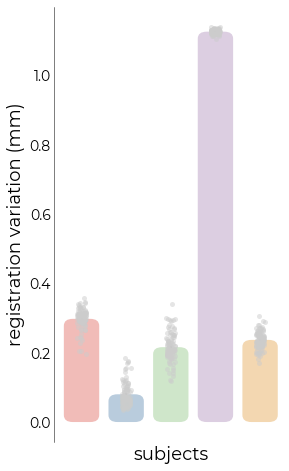

In [78]:
fig,axs = plt.subplots(figsize=(4,8))
plotting.LazyBar(
    data=df_reg,
    x="subject",
    y="euclidian",
    cmap=cmap_subj,
    axs=axs,
    sns_ori="v",
    x_label2="subjects",
    y_label2="registration variation (mm)",
    fancy=True,
    fancy_rounding=0.2,
    fancy_aspect=0.1,
    sns_offset=5,
    add_points=True,
    points_alpha=0.5,
    points_color="#cccccc",
    trim_bottom=True
)


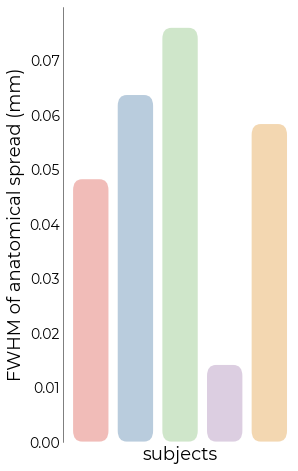

In [79]:
fig,axs = plt.subplots(figsize=(4,8))
y_fwhm = [i.fwhm for i in fwhm_objs]
plotting.LazyBar(
    x=subjects,
    y=y_fwhm,
    cmap=cmap_subj,
    axs=axs,
    sns_ori="v",
    x_label2="subjects",
    y_label2="FWHM of anatomical spread (mm)",
    fancy=True,
    fancy_rounding=0.2,
    fancy_aspect=0.01,
    sns_offset=5,
    # points_alpha=0.5,
    trim_bottom=True
)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-reg_fwhm")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

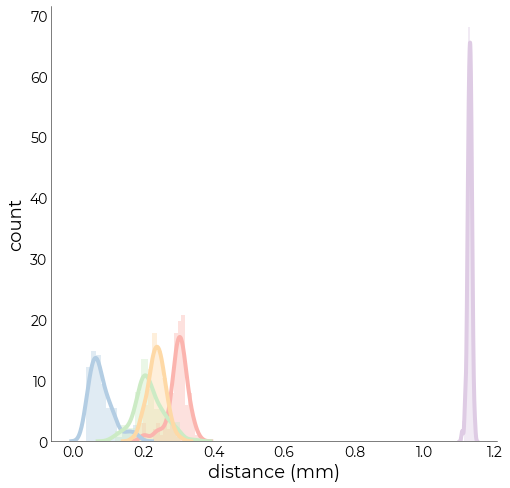

In [80]:
fig,axs = plt.subplots(figsize=(8,8))

for sub_ix,subject in enumerate(subjects):
    plotting.LazyHist(
        utils.select_from_df(df_reg, expression=f"subject = {subject}")['euclidian'].values,
        axs=axs,
        kde=True,
        hist=True,
        fill=False,
        y_label2="count",
        x_label2="distance (mm)",
        color=sub_colors[sub_ix],
        hist_kwargs={
            "alpha": 0.4
        },
        kde_kwargs={
            "linewidth": 4
        }
    )

fname = opj(fig_dir, f"sub-all_model-{model}_desc-reg_distr_single")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )    

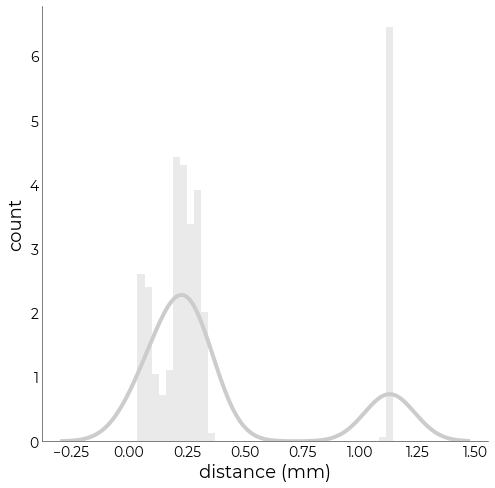

In [87]:
fig,axs = plt.subplots(figsize=(8,8))
plotting.LazyHist(
    df_reg.sort_values(["euclidian"])["euclidian"].values,
    axs=axs,
    kde=True,
    hist=True,
    fill=False,
    y_label2="count",
    x_label2="distance (mm)",
    color="#cccccc",
    hist_kwargs={
        "alpha": 0.4
    },
    kde_kwargs={
        "linewidth": 4
    }
)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-reg_distr_avg")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

In [23]:
subj = "sub-007"
space = "ses2"
coord = np.array([-19.4663,-100.799,-24.3312])
ff = utils.make_chicken_csv(coord, output_file=opj(os.environ.get("SUBJECTS_DIR"), subj, "mri", f"{subj}_space-{space}_hemi-L_vert-{subj_obj.get_target(subj)}_desc-lps.csv"))
!cat $ff

x,y,z,t,label,mass,volume,count
19.4663,100.799,-24.3312,0,1,1,0.343,1


In [30]:
# get target coordinate
# get reference and moving image
mov = utils.get_file_from_substring("orig.nii.gz", opj(base_dir, 'derivatives', 'freesurfer', subj, 'mri'))
ref = utils.get_file_from_substring(f"{subj}_ses-2_acq-MP2RAGE_T1w.nii.gz", opj(base_dir, subj, 'ses-2', 'anat'))

target_fs = opj(os.path.dirname(mov), f"{subj}_space-fs_hemi-L_vert-{subj_obj.get_target(subj)}_desc-lps.csv")
target_ses2 = np.array(utils.read_chicken_csv(opj(os.path.dirname(mov), f"{subj}_space-ses2_hemi-L_vert-{subj_obj.get_target(subj)}_desc-lps.csv")))
warp = utils.get_file_from_substring("from-fs_to-ses2", opj(base_dir, 'derivatives', 'pycortex', subj, 'transforms'))

print(target_fs)
print(target_ses2)

/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/freesurfer/sub-007/mri/sub-007_space-fs_hemi-L_vert-4578_desc-lps.csv
[ 19.4663 100.799  -24.3312]


In [39]:
from linescanning import transform
# warp = utils.getfile_from_substring(["from-fs_to-ses2", "txt"], opj(base_dir, 'derivatives', 'pycortex', subj, 'transforms'))
warp = opj(base_dir, 'derivatives', 'pycortex', subj, 'transforms', 'tmp.txt')
transform.ants_applytopoints(
    target_fs,
    'tmp.csv',
    warp
)
!cat tmp.csv

x,y,z,t,label,mass,volume,count
19.8801,101.422,-23.1231,0,1,1,0.343,1


In [34]:
np.linalg.norm(target_ses2-np.array([19.3486,100.884,-23.2153]))

1.1253048920181583

### Check V1-fit

In [29]:
v1_fn = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-1/sub-001_ses-1_task-2R_roi-V1_hemi-LR_desc-avg_bold.npy"
v1_data = np.load(v1_fn)
v1_pars = opj(os.path.dirname(v1_fn), "sub-001_ses-1_task-2R_roi-V1_model-norm_stage-iter_desc-prf_params.pkl")
v1_dm = opj(os.path.dirname(v1_fn), "design_task-2R.mat")

In [31]:
v1_fit = prf.pRFmodelFitting(
    v1_data.T,
    design_matrix=v1_dm,
    TR=1.5,
    verbose=True
)

v1_fit.load_params(v1_pars, model="norm", stage="iter")

Reading design matrix from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-1/design_task-2R.mat'
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0]
Using constraint(s): ['tc', 'tc']
Reading settings from pickle-file (safest option; overwrites other settings)
Inserting parameters from <class 'str'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f39467cca30>


In [38]:
v1_fit.norm_iter.shape

(307361, 10)

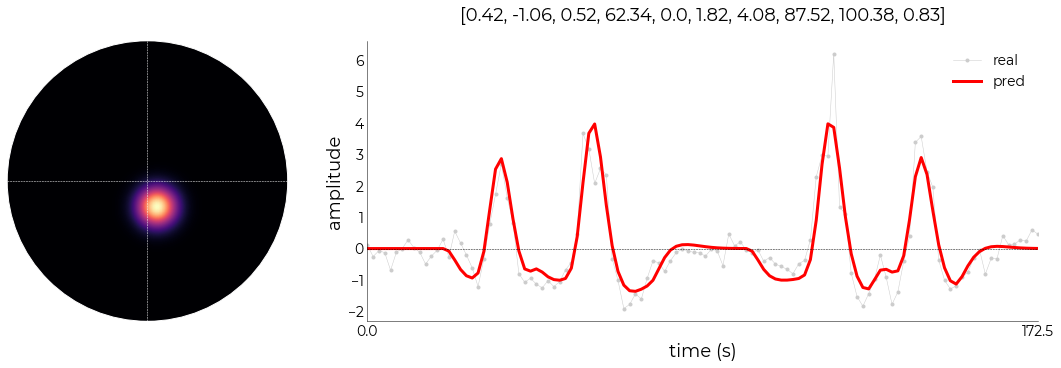

In [42]:
_,_,_,_ = v1_fit.plot_vox(vox_nr=1053, title="pars", model="norm")

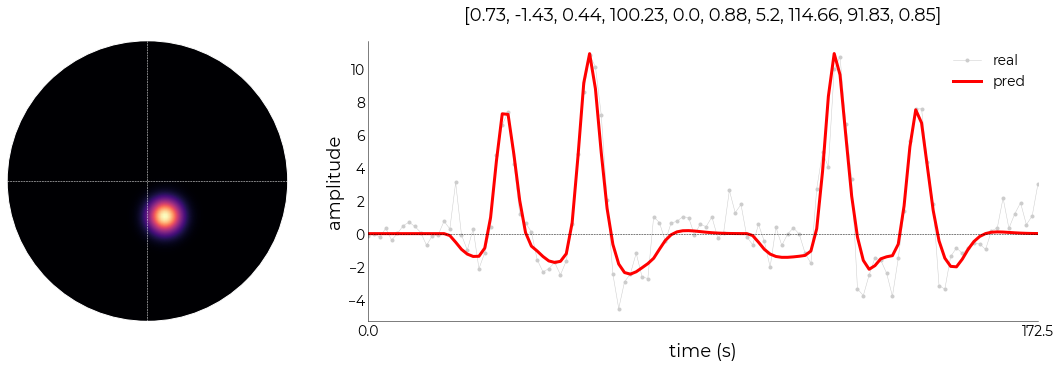

In [37]:
est_idx = np.where(np.array(full_dict["sub-001"]["vertices"]["all"]) == subj_obj.get_target("sub-001"))[0][0]
_,_,_,_ = full_dict["sub-001"]["wb"]["avg"].plot_vox(vox_nr=est_idx, title="pars", model="norm")

In [43]:
inputdir = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored"
search_for = ['run-', 'task-2R', 'desc-denoised_bold.npy', 'space-fsnative']
files = utils.get_file_from_substring(search_for, inputdir)
files

['/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-10_space-fsnative_hemi-L_desc-denoised_bold.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-10_space-fsnative_hemi-R_desc-denoised_bold.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-11_space-fsnative_hemi-L_desc-denoised_bold.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-11_space-fsnative_hemi-R_desc-denoised_bold.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-12_space-fsnative_hemi-L_desc-denoised_bold.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-12_space-fsnative_hemi-R_desc-

In [53]:
[[i, j] for i, j in zip(files[:-1], files[1:])]

[['/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-10_space-fsnative_hemi-L_desc-denoised_bold.npy',
  '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-10_space-fsnative_hemi-R_desc-denoised_bold.npy'],
 ['/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-10_space-fsnative_hemi-R_desc-denoised_bold.npy',
  '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-11_space-fsnative_hemi-L_desc-denoised_bold.npy'],
 ['/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-11_space-fsnative_hemi-L_desc-denoised_bold.npy',
  '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-001/ses-1/unzscored/sub-001_ses-1_task-2R_run-11_space-fsnative_hemi

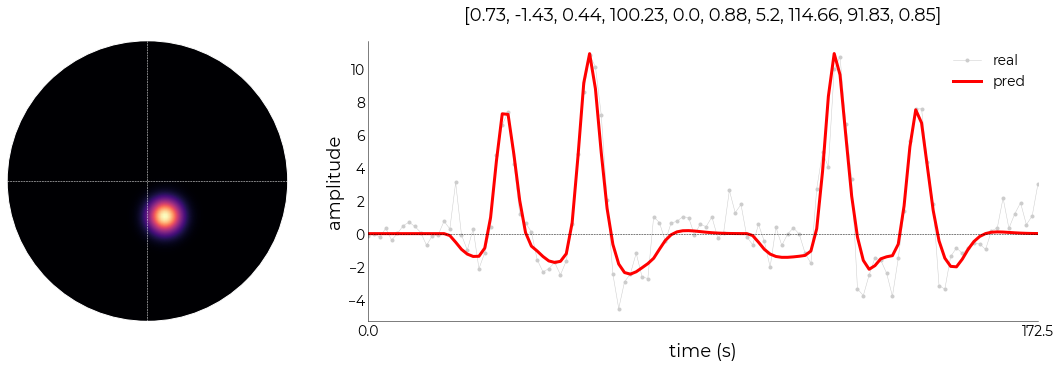

In [60]:
est_idx = np.where(np.array(full_dict["sub-001"]["vertices"]["all"]) == subj_obj.get_target("sub-001"))[0][0]
_,_,_,_ = full_dict["sub-001"]["wb"]["avg"].plot_vox(vox_nr=est_idx, title="pars", model="norm")

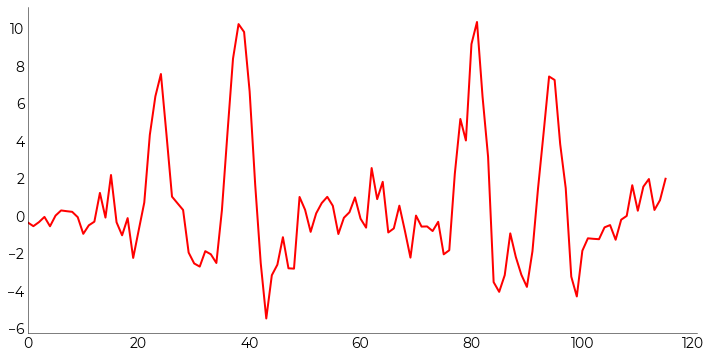

In [91]:
tc = np.load("/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-1/sub-001_ses-1_task-2R_roi-V1_hemi-LR_desc-avg_bold.npy")[:,1053]
plotting.LazyPlot(
    tc.T,
    line_width=2,
    color="r",
    figsize=(12,6)
)

### Figure comparing line-scanning & 2D-EPI timecourses

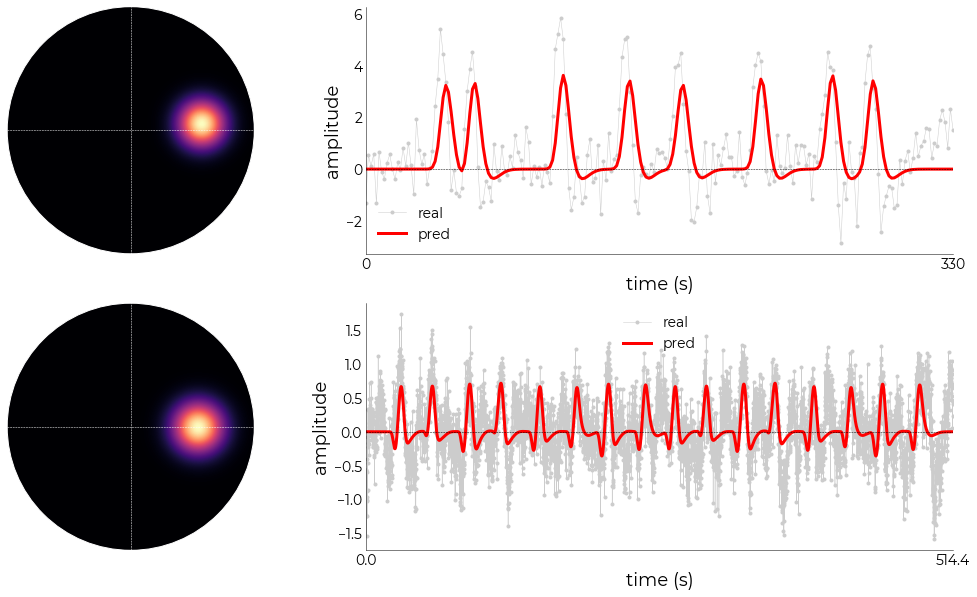

In [207]:
subj = "sub-002"

fig,axs = plt.subplots(ncols=2,nrows=2, figsize=(20,10), gridspec_kw={"wspace": -0.1})

est_idx = np.where(np.array(full_dict[subj]["vertices"]["all"]) == subj_obj.get_target(subj))[0][0]
_,_,_,_ = full_dict[subj]["wb"]["avg"].plot_vox(
    vox_nr=est_idx, 
    model="norm",
    axs=[axs[0,0],axs[0,1]])

_,_,_,_ = full_dict[subj]["lines"]["native"]["avg"].plot_vox(
    model="norm",
    axs=[axs[1,0],axs[1,1]])

fname = opj(fig_dir, subj, f"sub-002_model-{model}_desc-tc_comparison")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

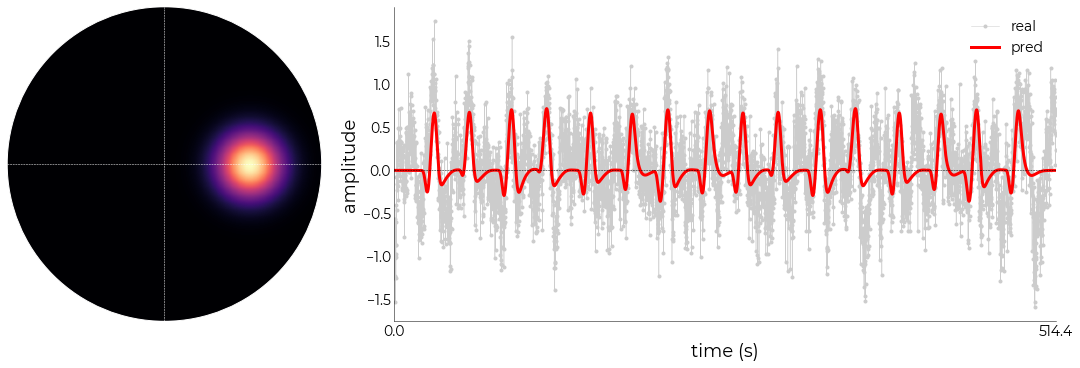

In [200]:
_,_,_,_ = full_dict[subj]["lines"]["native"]["avg"].plot_vox(model="norm")